## Projet 6 : Classifiez automatiquement des biens de consommation

## Contexte

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

## Librairies utilisées avec le langage Python:

In [ ]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from gensim.models.phrases import Phrases
import nltk
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud
from pandarallel import pandarallel
pandarallel.initialize()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import csr_matrix
import multiprocessing
import os
import warnings
warnings.filterwarnings('ignore')


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

pandarallel.initialize(progress_bar=True, nb_workers = 6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Données textuelles brutes:

In [ ]:
# Importation de data :
data = pd.read_csv('D:/tutorial-env/OCR/Projet6/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [ ]:
data.shape

(1050, 15)

In [ ]:
data.describe(include = 'all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000

Le dataframe textuelle contient 15 variables et 1050 produits.

## Création du dataframe de classification textuelle :

Nous ne garderons que les variables intéressantes pour notre cas d'usage, c'est à dire la classification des descriptions textuelles et des images des produits.

Gardons les variables :
- product_name (identifiant unique produit),
- product_category_tree (classification cible),
- image (référence unique à l'image produit),
- description (données à classifier).


In [ ]:
# Dataframe des variables sélectionnées :
data_txt = data [[
    'product_name',
    'description',
    'image',
    'product_category_tree'
    ]]

data_txt.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                               product_category_tree  
0  ["Home Furnishing >> Curtains & Accessories >>...  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...

In [ ]:
data_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           1050 non-null   object
 1   description            1050 non-null   object
 2   image                  1050 non-null   object
 3   product_category_tree  1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [ ]:
# Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data : pd.DataFrame) -> pd.DataFrame:

    '''Prend dataframe `data` en entrée et calcule le pourcentage de valeurs manquantes pour chaque colonne
    Args:
        data (pd.DataFrame): Dataframe sur lequel les pourcentages de valeurs manquantes seront calculées
    Sortie:
        pd.DataFrame: Dataframe avec le pourcentage de valeurs manquantes pour chaque colonne

    '''
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        #Calcul du pourcentage de valeurs manquantes
        miss_val.append(data[item].isna().mean())

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    num_total_vars = data.shape[1]
    num_vars_missing = output[output['miss_val'] != 0].shape[0]
    print (f"Notre dataframe a  {num_total_vars} variables.\n"
           f"Il y a  {num_vars_missing} variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val'] != 0].sort_values('miss_val')


In [ ]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_txt_vm = show_miss_val(data_txt)
data_txt_vm.head(5)

Notre dataframe a  4 variables.
Il y a  0 variables contenant des valeurs manquantes.


Empty DataFrame
Columns: [variable, miss_val]
Index: []

Notre dataframe de classification textuelle contient 4 variables et 1050 produits.

Aucune valeur manquante n'est présente dans ce dataframe.

In [ ]:
data_txt.duplicated().sum()

0

Aucun doublon n'est présent dans notre dataframe de classification textuelle, ce qui est en adéquation avec le faitque nous ayons gardé des variables qui ont autant de "catégories" que de produits, excepté la variable product_category_tree (cible de classification).

Il n'y a pas de nettoyage spécifique à faire dans notre dataframe de classification textuelle.

## Analyse exploratoire univariée :

### Cible : product_category_tree

Commençons pas séparer cette colonne avec un "arbre de catégories" avec 642 valeurs uniques, ce qui est trop élevé, en plusieurs colonnes par niveau de l'arbre des catégories.

In [ ]:
#Traitement des catégories
def separation_categories(data : pd.DataFrame,
                          col : str)-> pd.DataFrame :
    '''Prend une colonne 'col' de dataframe `data` en entrée contenant un arbre de catégorie et la sépare en plusieurs colonnes par niveau de catégorie
    Args:
        data (pd.DataFrame): Dataframe à analyser
        col (str): Nom de la colonne à séparer
    Sortie:
        pd.DataFrame: Dataframe avec les arbres de catégories séparées en plusieurs colonnes

    '''
    for  items in data[col]:
      item = items.split('["')[1].split('"]')[0]
      cat = item.split(' >> ')
      nb_cat = len(cat)
      for n in range (0, nb_cat):
        name_col = 'cat_niv_' + str(n + 1)
        if name_col not in data.columns:
          data[name_col] = np.nan
        data.loc[data[col] == items,name_col] = cat[n]
    return data

In [ ]:
data_txt_sep = separation_categories(data_txt, 'product_category_tree')
data_txt_sep

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_niv_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                   cat_niv_2         cat_niv_3  \
0     Curtains & Accessories          Curtains   
1           Baby Bath & Skin  Baby Bath Towels   
2           Baby Bath & Skin  Baby Bath Towels   
3                  Bed Linen         Bedsheets   
4                  Bed Linen         Bedsheets   
...                      ...               ...   
1045       Baby & Kids Gifts          Stickers   
1046       Baby & Kids Gifts          Stickers   
1047       Baby & Kids Gifts          Stickers   
1048       Baby & Kids Gifts          Stickers   
1049       Baby & Kids Gifts          Stickers   

                                              cat_niv_4  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                             Sathiyas Baby Bath Towels   
2                              Eurospa Baby Bath Towels   
3                       SANTOSH ROYAL FASHION Bedsheets   
4                                Jaipur Print Bedsheets   
...                                                 ...   
1045                              Oren Empower Stickers   
1046                                Wallmantra Stickers   
1047                       

In [ ]:
data_txt_sep.describe(include = 'all')

product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

                                       image  \
count                                   1050   
unique                                  1050   
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                                       1   

                                    product_category_tree        cat_niv_1  \
count                                                1050             1050   
unique                                                642                7   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  Home Furnishing   
freq                                                   56              150   

            cat_niv_2   cat_niv_3 cat_niv_4 cat_niv_5     cat_niv_6  \
count            1050        1047       679       405           127   
unique             62         241       349       297           117   
top     Wrist Watches  Deodorants    Combos   Dresses  Wow! Dresses   
freq              149          65        64        21             3   

                                                cat_niv_7  
count                                                  57  
unique                                                 57  
top     Mom and Kid Baby Girl's Printed Green Top & Py...  
freq                                                    1

Les arbres de catégories contiennent jusqu'à 7 niveaux.

In [ ]:
data_txt_sep_vm = show_miss_val(data_txt_sep)
data_txt_sep_vm.head(10)

Notre dataframe a  11 variables.
Il y a  5 variables contenant des valeurs manquantes.


variable  miss_val
6   cat_niv_3  0.002857
7   cat_niv_4  0.353333
8   cat_niv_5  0.614286
9   cat_niv_6  0.879048
10  cat_niv_7  0.945714

Au vu du nombre de valeurs uniques et de valeurs manquantes, gardons seulement les deux premières catégories et étudions les :

In [ ]:
# Suppression des colonnes inutiles
data_txt_sep.drop(columns = ['cat_niv_3', 'cat_niv_4', 'cat_niv_5', 'cat_niv_6', 'cat_niv_7'], inplace = True)
data_txt_sep.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                               product_category_tree        cat_niv_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   

                cat_niv_2  
0  Curtains & Accessories  
1        Baby Bath & Skin  
2        Baby Bath & Skin  
3               Bed Linen  
4               Bed Linen

In [ ]:
def describe_data_qual(data: pd.DataFrame,
                    col: str) :
    '''Génère des visualisation graphiques pour une colonne catégorielle d'un dataframe
    Args:
        data (pd.DataFrame): Dataframe contenant les données à analyser
        col (str): Nom de la colonne que l'on veut analyser
    Sortie:
        Histogramme des fréquences des catégories de la colonne
        Diagramme circulaire des fréquences des catégories de la colonne
    '''
    # Filtrage des données nulles
    mask = data[col].notnull()
    df = data[mask]

    # Données à visualiser
    x=df[col]

    # Fréquences et étiquettes triées par index
    labels = list(x.value_counts().sort_values(ascending = False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending = False)

    # Propriétés graphiques de la figure principale
    fig = plt.figure(figsize=(18,10))
    plt.suptitle(f"Distribution de : {col}", fontsize=25)

    # Propriétés graphiques du premier graphique (histogramme)
    ax1 = plt.subplot(121)
    ax1.set_ylabel(col, fontsize=20)
    ax1.set_xlabel("Frequences", fontsize=20)

    # Propriétés graphiques du deuxième graphique (diagramme circulaire)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Frequences en %", fontsize=20)

    # Tracer les graphiques
    ax1.barh(labels, frequencies)
    ax2.pie(frequencies,autopct='%1.2f%%',shadow=True )

    # Ajouter une légende
    ax2.legend(labels, loc = 'upper right', bbox_to_anchor = (1.5, 1))

    # Afficher les graphiques
    plt.show()

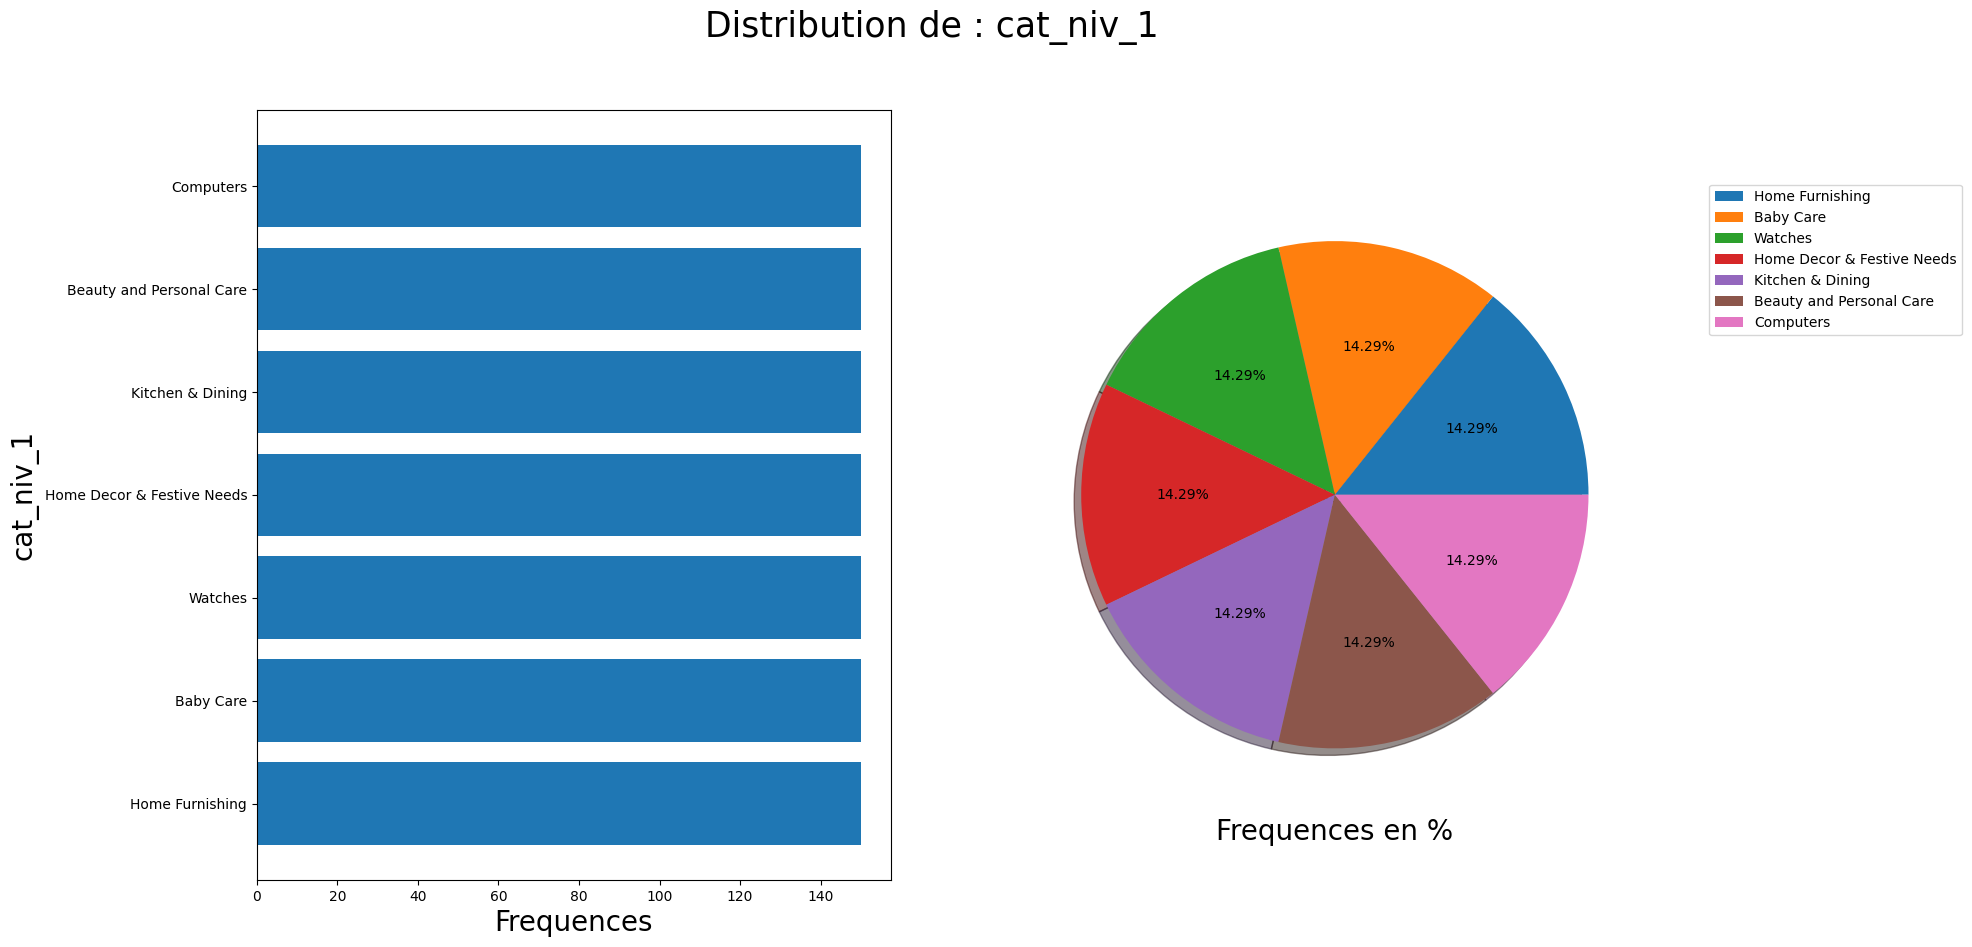

In [ ]:
describe_data_qual(data_txt_sep, 'cat_niv_1')

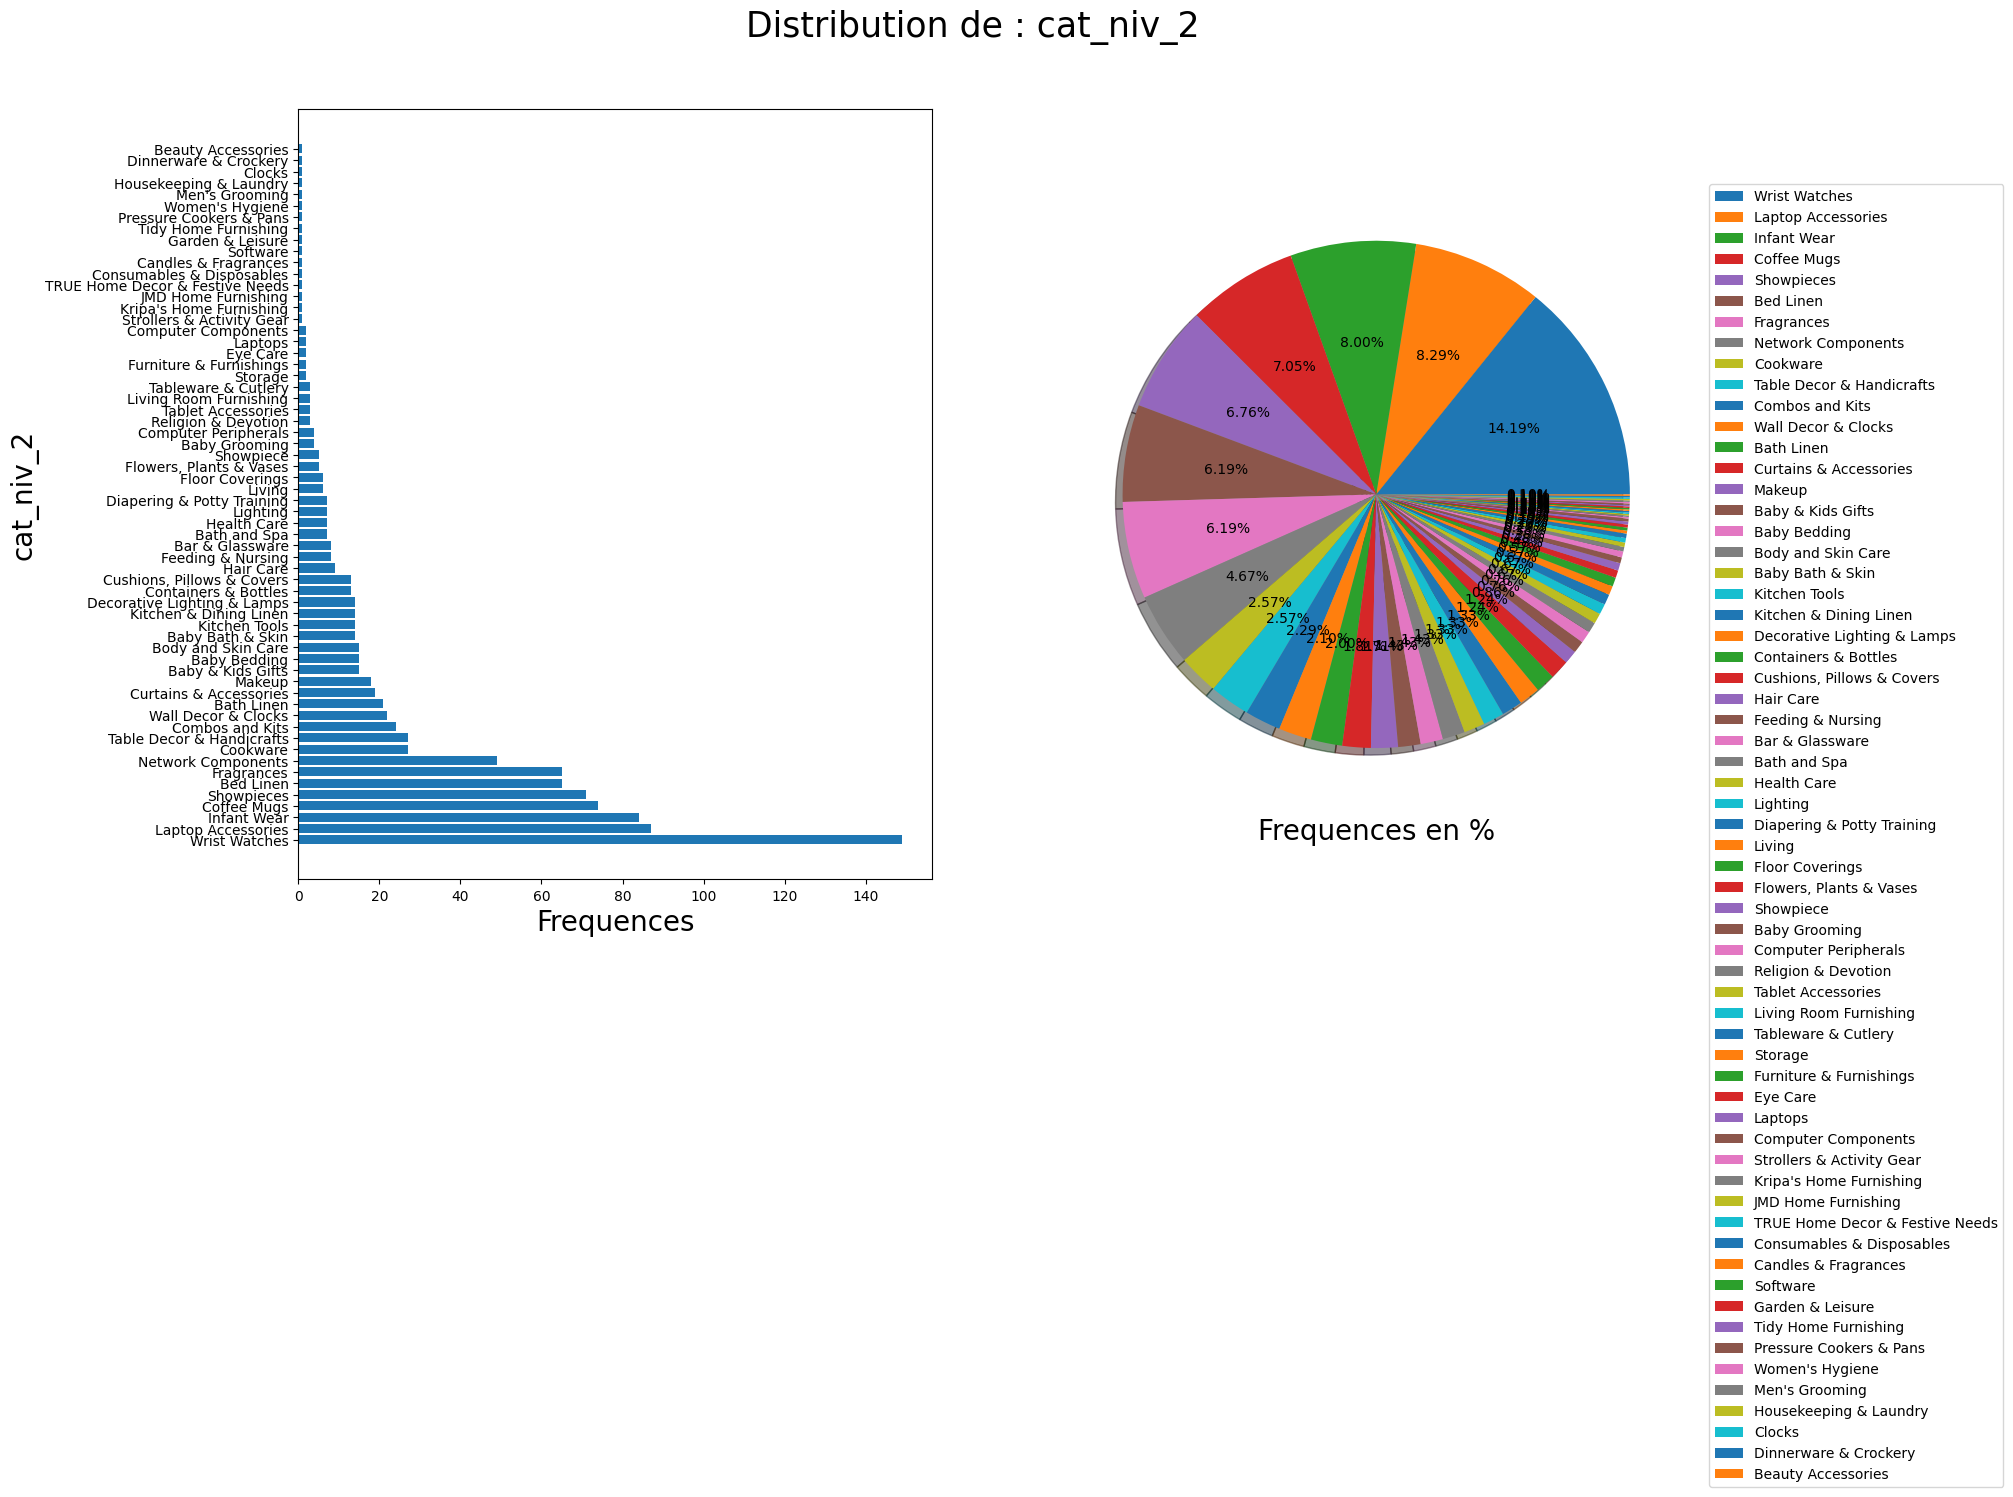

In [ ]:
describe_data_qual(data_txt_sep, 'cat_niv_2')

Certaines catégories de niveau 2 sont très largement sous-représentées par rapport aux autres, concentrons-nous donc seulement sur la première catégorie pour la classification.

### Variable texte : description

In [ ]:
data_txt_sep.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

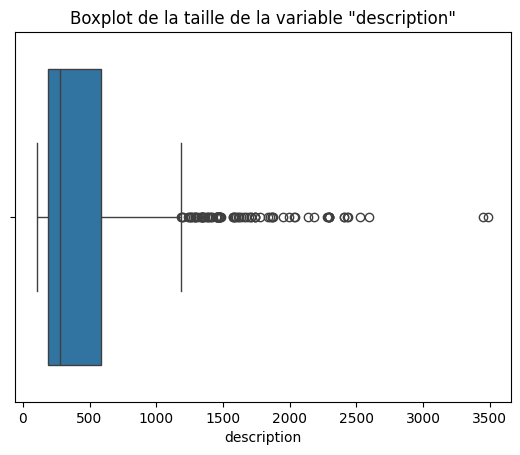

In [ ]:
tmp=data_txt_sep.description.str.len()
sns.boxplot(x = tmp, orient = 'h')
plt.title(f'Boxplot de la taille de la variable "description"')
plt.show()

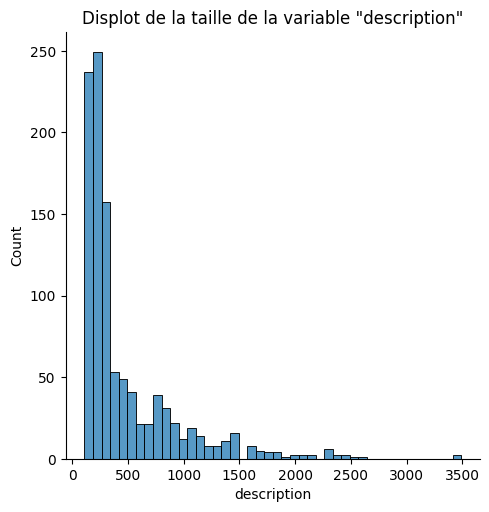

In [ ]:
sns.displot(tmp)
plt.title(f'Displot de la taille de la variable "description"')
plt.show()

Peu de textes descriptifs ont une taille supérieure à 1200 caractères. La grande majorité a une taille inférieure à 300 caractères.

Ajoutons la taille au dataframe :

In [ ]:
data_txt_sep['_taille_description'] = tmp
data_txt_sep

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_niv_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                   cat_niv_2  _taille_description  
0     Curtains & Accessories                 1420  
1           Baby Bath & Skin                  444  
2           Baby Bath & Skin                 1258  
3                  Bed Linen                  858  
4                  Bed Linen                 1197  
...                      ...                  ...  
1045       Baby & Kids Gifts                 2432  
1046       Baby & Kids Gifts                 1660  
1047       Baby & Kids Gifts                  262  
1048       Baby & Kids Gifts                  210  
1049       Baby & Kids Gifts                  187  

[1050 rows x 7 columns]

## Analyse exploratoire multivariée :


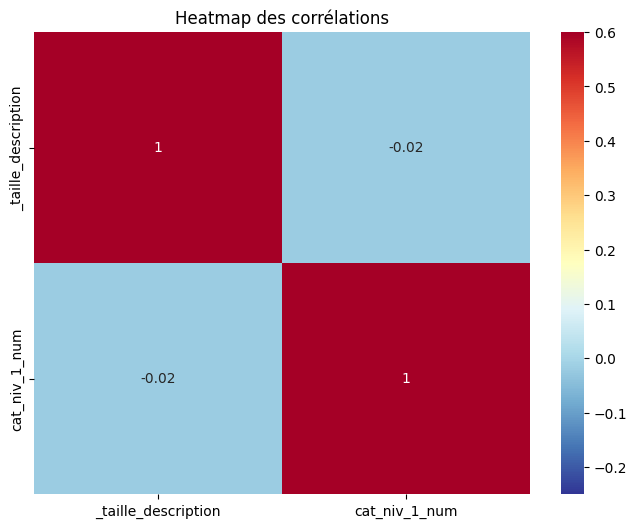

In [ ]:
encoder = LabelEncoder()

# Encodage de la variable cat_niv_1
data_txt_sep['cat_niv_1_num'] = encoder.fit_transform(data_txt_sep['cat_niv_1'])

plt.figure(figsize = (8, 6))

# Sélection des colonnes numériques
data_corr = data_txt_sep.select_dtypes(include=['int64', 'int32'])

# Heatmap des correlations
sns.heatmap(data_corr.corr(),
            cmap = plt.cm.RdYlBu_r,
            vmin = -0.25,
            vmax = 0.6,
            annot = True)
plt.title('Heatmap des corrélations')
plt.show()

Il apparait qu'il n'existe pas de corrélation entre la taille des descriptions et la catégorie du produit.

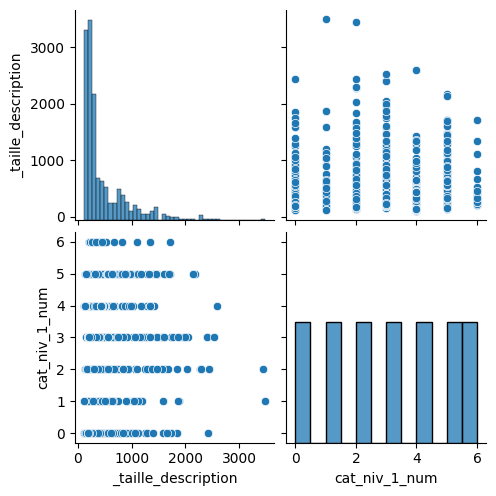

In [ ]:
sns.pairplot(data_corr)
plt.show()

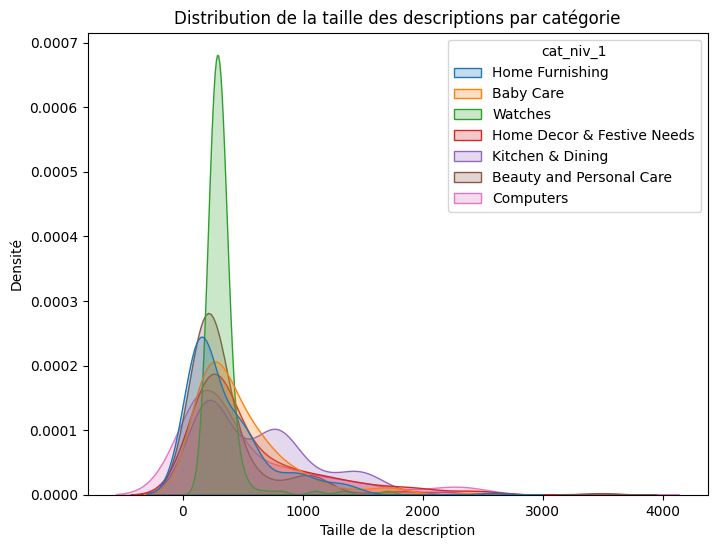

In [ ]:
plt.figure(figsize = (8, 6))
sns.kdeplot( x = '_taille_description', hue = 'cat_niv_1', data = data_txt_sep, fill = True)
plt.title('Distribution de la taille des descriptions par catégorie')
plt.xlabel('Taille de la description')
plt.ylabel('Densité')
plt.show()

Les distributions des tailles de descriptions sont assez similaires entre les différentes catégories.

On peut cependant noter que la distribution est plus concentrée autour de 300 caractères pour la catégorie "Watches" et qu'il y a plus de descriptions longues dans la catégorie "Kitchen and Dining" comparé aux autres.

## Traitement des données de la variable "description" :

### Recherche de la meilleure tokenisation

In [ ]:
# Sélection de 10 descriptions au hasard :
txt = []
for i in range (0, 10) :
     txt.append(data_txt_sep['description'].sample(1).values[0].lower())
display(txt)


['buy prestige deluxe plus 10 l pressure cooker for rs.2345 online. prestige deluxe plus 10 l pressure cooker at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee.',
 'vizion 8502-7purple sports series digital watch  - for boys, girls\r\n                         price: rs. 595\r\n\t\t\t\t\r\n\t\t\tbrand: vizion,sports series watch for kids,1 year manufacturer warranty,digital display,automatic movement,metal case and solid body ,dial shape:round,dial dimension:22mm ,strap material:silicone ,strap width:20mm,water resistant,night display cold backlight, daily alarm,hour minute second ,date week display, 12/24 hour format,attractive brand packaging- tuff plastic box,note: in case of non-receipt of warranty card, please intimate us within 48 hours,disclaimer: product color may slightly vary due to photographic lighting sources or your monitor settings (the image has been enlarged for better viewing)\r\nbrand: vizion,sports series watch 

In [ ]:
# Initialisation de la liste de stopwords anglais
stopwords = set(stopwords.words('english'))

# Test de différentes tokenisations :
# le Word Tokenizer se base sur les espaces, le WordPunctTokenizer tient compte de la ponctuation et le RegexpTokenizer utilise des expressions régulières pour une segmentation plus flexible.
for i, doc in enumerate(txt):

    print('**'*50)
    print(f'---> doc_{i}\n')

    # Test de la tokenisation via word_tokenize avec filtrage des stops_words :
    print('Résultat avec word_tokenizer : \n')
    token = word_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via wordpunct_tokenize avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec wordpunct_tokenize : \n')
    token = wordpunct_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via RegexpTokenizer avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec RegexpTokenizer : \n')
    token = RegexpTokenizer(r'\w+').tokenize(doc) # ici le tokenizer ignore la ponctuation et sépare les mots en utilisant uniquement les caractères alphanumériques et le caractère de soulignement
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

****************************************************************************************************
---> doc_0

Résultat avec word_tokenizer : 

34 24
----------------------------------------
Résultat avec wordpunct_tokenize : 

36 25
----------------------------------------
Résultat avec RegexpTokenizer : 

30 23
****************************************************************************************************
---> doc_1

Résultat avec word_tokenizer : 

219 81
----------------------------------------
Résultat avec wordpunct_tokenize : 

243 88
----------------------------------------
Résultat avec RegexpTokenizer : 

176 81
****************************************************************************************************
---> doc_2

Résultat avec word_tokenizer : 

41 27
----------------------------------------
Résultat avec wordpunct_tokenize : 

45 29
----------------------------------------
Résultat avec RegexpTokenizer : 

33 25
**********************************************

La meilleure tokenisation est effectuée via RegexpTokenizer car c'est celui qui amène au minimum de token.

### Première fonction de pré-processing

In [ ]:
def preprocess (txt: str,
                stopwords: list,
                n_gram_range = (1,3)) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
  Sortie:
        Liste de tokens du texte sans stopwords
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  return token_clean

### Personnalisation de la liste de stopwords

In [ ]:
# Fusion de tout le corpus
corpus = " ".join( data_txt_sep['description'].values)
len(corpus)

498561

In [ ]:
# Tokenisation sur tout le corpus
corpus_tokenised = preprocess(corpus, stopwords)
print(f"Il y a  {len(corpus_tokenised)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised))} tokens uniques.")

Il y a  247141 tokens.
Il y a  56890 tokens uniques.


In [ ]:
# Transformation de la colonne "description" en tokens
tmp = pd.Series(corpus_tokenised).value_counts()
tmp.head(45)

rs                        1822
products                  1262
free                      1236
buy                       1162
delivery                  1134
cash                      1128
shipping                  1128
genuine                   1128
replacement               1118
1                         1108
cm                        1086
day                       1080
30                         996
flipkart                   962
com                        946
guarantee                  942
online                     792
features                   790
specifications             742
price                      704
watch                      660
color                      656
mug                        654
baby                       640
pack                       634
material                   624
set                        620
type                       608
cotton                     598
box                        584
general                    576
5                          572
shipping

In [ ]:
tmp.tail(45)

size face towel                       1
cms specifications eurospa            1
face towel 23                         1
towel 23 cms                          1
23 cms x                              1
cms x 23                              1
x 23 cms                              1
23 cms specifications                 1
name shuvam20pcftsetassorted ideal    1
boys girls men                        1
printed wedding gifted                1
gifting specifications santosh        1
double bedsheet royal                 1
bedsheet royal bedsheet               1
royal bedsheet perfact                1
bedsheet perfact wedding              1
perfact wedding gifting               1
wedding gifting specifications        1
royal fashion machine                 1
package 20 piece                      1
fashion machine washable              1
name gold design                      1
gold design royal                     1
design royal cotton                   1
royal cotton printed                  1


In [ ]:
tmp.describe()

count    56890.000000
mean         4.344191
std         28.384682
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1822.000000
Name: count, dtype: float64

50% des tokens ne sont présents qu'une ou deux fois ce qui parait peu pertinents pour une classification.

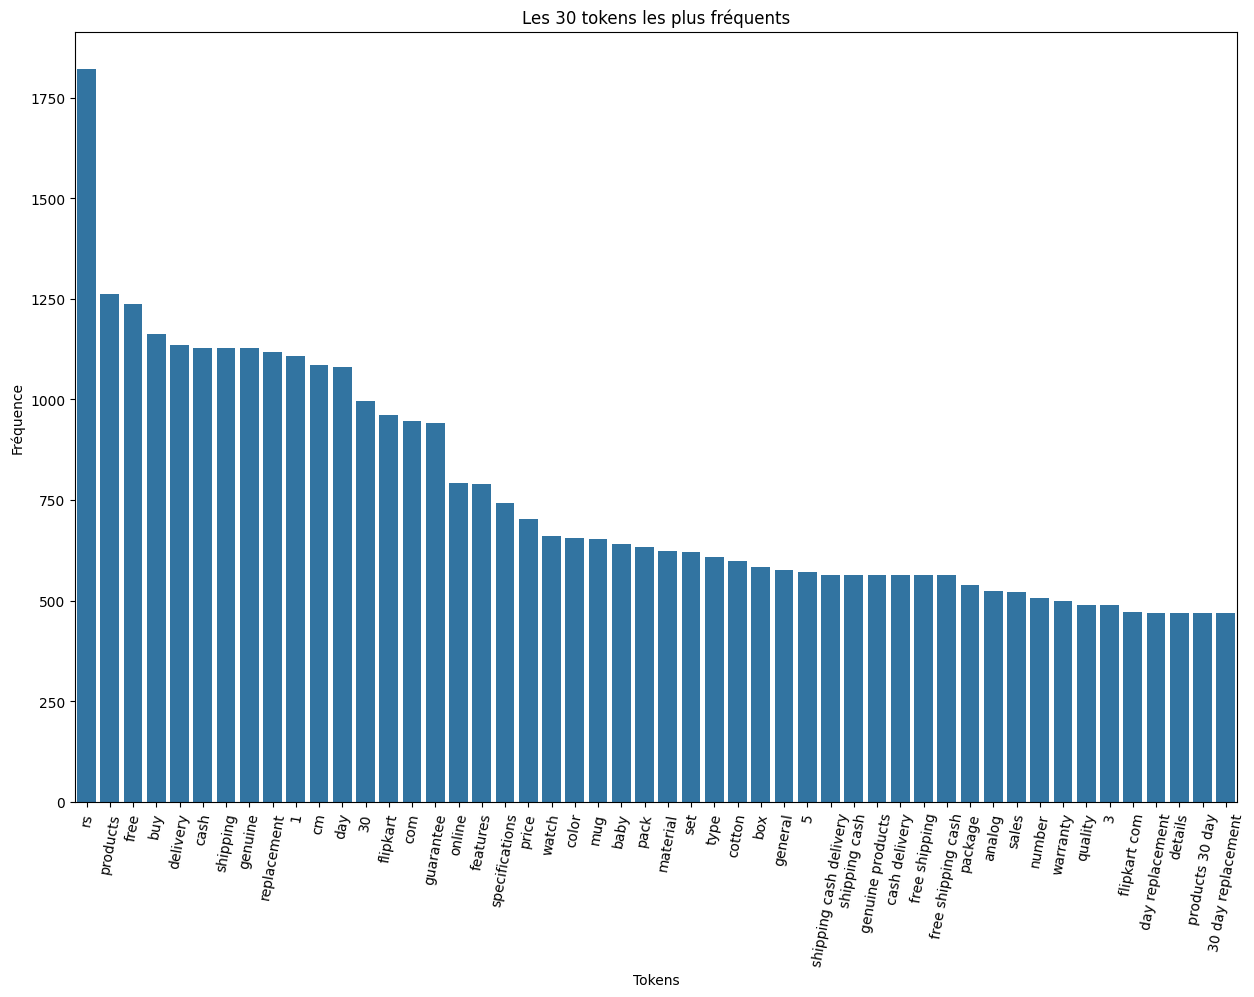

In [ ]:
# Visualisation des 30 tokens les plus fréquents
plt.figure(figsize = (15,10))
sns.barplot(x = tmp.index[:50], y = tmp.values[:50])
plt.xticks(rotation = 80)
plt.title('Les 30 tokens les plus fréquents')
plt.xlabel('Tokens')
plt.ylabel('Fréquence')
plt.show()

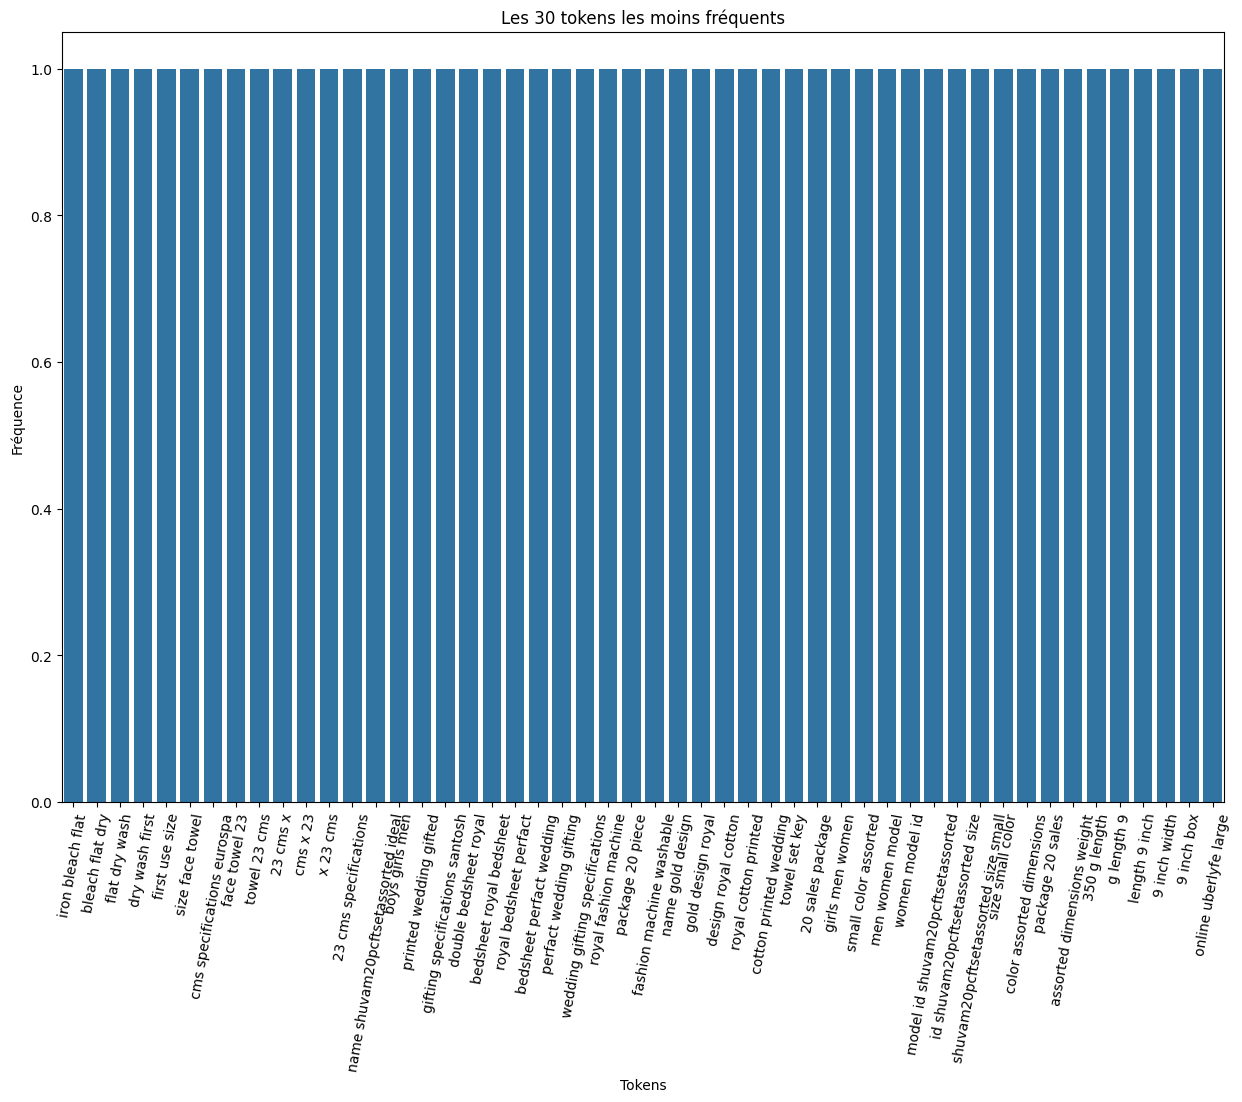

In [ ]:
# Visualisation des 30 tokens les moins fréquents
plt.figure(figsize = (15,10))
sns.barplot(x = tmp.index[-50:], y = tmp.values[-50:])
plt.xticks(rotation = 80)
plt.title('Les 30 tokens les moins fréquents')
plt.xlabel('Tokens')
plt.ylabel('Fréquence')
plt.show()

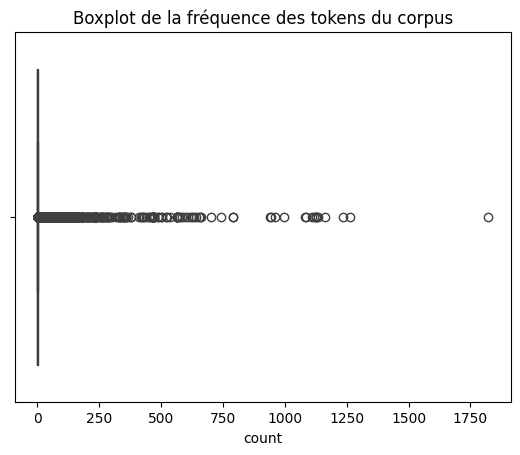

In [ ]:
sns.boxplot(tmp, orient = 'h')
plt.title(f'Boxplot de la fréquence des tokens du corpus')
plt.show()

On note que la distribution de la fréquence des tokens est déséquilibrée et que certains tokens très fréquent sont peu pertinents dans le cadre de notre classification, de même pour des tokens peu fréquents.

On décide donc de ne pas garder :
- les tokens qui n'apparaissent qu'une fois,
- les 20 tokens les plus fréquents,
- les tokens de moins de 3 caractères,
- les tokens non alphabétiques

car ils ne seront pas pertinents pour notre classification.

On ajoute donc les 20 tokens les plus fréquents à notre liste de stopwords :

In [ ]:
stopword_liste = list(stopwords)
temp = tmp[:20].index
for i, word in enumerate (temp):
  stopword_liste.append(word)

### Deuxième fonction de pré-processing

In [ ]:
def preprocess2 (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  # filtrage selon la fréquence min et max
  tmp = pd.Series(token_clean).value_counts()
  token_clean = [w for w in token_clean if (tmp[w] >= freq_min) & (tmp[w] <= freq_max)]

  return token_clean

In [ ]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_2= preprocess2(corpus, stopword_liste, 2, 700, 3)
print(f"Il y a  {len(corpus_tokenised_2)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_2))} tokens uniques.")

Il y a  155179 tokens.
Il y a  20924 tokens uniques.


In [ ]:
pd.Series(corpus_tokenised_2).value_counts().describe()

count    20924.000000
mean         7.416316
std         27.032744
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        660.000000
Name: count, dtype: float64

Nous avons diminué le nombre de tokens unique. Continuons en effectuants un stemming ou une lemmatisation.

### Troisième fonction de pré-processing avec stemming ou lemmatisation

In [ ]:
def preprocess3 (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True,
                stem_lemm = "stem") -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
        stem_lemm (str): Si "stem", stemmatise les tokens, si "lemm" lemmatises les tokens
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += ['_'.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  # filtrage selon la fréquence min et max
  tmp = pd.Series(token_clean).value_counts()
  token_clean = [w for w in token_clean if (tmp[w] >= freq_min) & (tmp[w] <= freq_max)]

  # Stemming ou lematisation
  if stem_lemm == "stem":
    transf = PorterStemmer()
    token_clean = [transf.stem(w) for w in token_clean]
  if stem_lemm == "lemm":
    transf = WordNetLemmatizer()
    token_clean = [transf.lemmatize(w) for w in token_clean]
  else:
    pass

  return token_clean

In [ ]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_3_stem = preprocess3(corpus, stopword_liste, 2, 700, 3, stem_lemm = "stem")
print(f"Il y a  {len(corpus_tokenised_3_stem)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_3_stem))} tokens uniques.")

Il y a  155179 tokens.
Il y a  19854 tokens uniques.


In [ ]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_3_lemm = preprocess3(corpus, stopword_liste, 2, 700, 3, stem_lemm = "lemm")
print(f"Il y a  {len(corpus_tokenised_3_lemm)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_3_lemm))} tokens uniques.")

Il y a  155179 tokens.
Il y a  20515 tokens uniques.


Le stemming est le plus efficace pour diminuer le nombre de tokens unique.

### Visualisation des tokens du corpus pré-traité

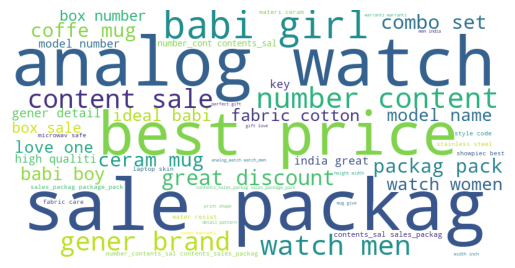

In [ ]:
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_3_stem))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Visualisation des tokens du corpus pré-traité selon les catégories

In [ ]:
#Séparation du dataframe en fonction des catégories :
# 0 = Baby Care
# 1 = Beauty and Personal Care
# 2 = Computers
# 3 = Home Decor and Festive Needs
# 4 = Home Furnishing
# 5 = Kitchen and Dining
# 6 = Watches
data_txt_sep_0 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 0]
data_txt_sep_1 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 1]
data_txt_sep_2 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 2]
data_txt_sep_3 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 3]
data_txt_sep_4 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 4]
data_txt_sep_5 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 5]
data_txt_sep_6 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 6]


In [ ]:
#Création des différents corpus par catégories
corpus_0 = " ".join( data_txt_sep_0.description)
corpus_1 = " ".join( data_txt_sep_1.description)
corpus_2 = " ".join( data_txt_sep_2.description)
corpus_3 = " ".join( data_txt_sep_3.description)
corpus_4 = " ".join( data_txt_sep_4.description)
corpus_5 = " ".join( data_txt_sep_5.description)
corpus_6 = " ".join( data_txt_sep_6.description)

In [ ]:
# Tokenisation des différents corpus par catégories
for i in range (0,7) :
  name_corpus = f"corpus_{i}"
  name_corpus_tokenised = f"corpus_tokenised_{i}"
  globals()[name_corpus_tokenised] = preprocess3(globals()[name_corpus], stopword_liste, 2, 700, 3, stem_lemm = "stem")
  print(f"Dans {name_corpus} : \n"
        f"Il y a  {len( globals()[name_corpus_tokenised])} tokens.\n"
        f"Il y a  {len(set( globals()[name_corpus_tokenised]))} tokens uniques.\n"
        f"***************************************************************")

Dans corpus_0 : 
Il y a  26469 tokens.
Il y a  3876 tokens uniques.
***************************************************************
Dans corpus_1 : 
Il y a  14946 tokens.
Il y a  2858 tokens uniques.
***************************************************************
Dans corpus_2 : 
Il y a  25893 tokens.
Il y a  3304 tokens uniques.
***************************************************************
Dans corpus_3 : 
Il y a  25310 tokens.
Il y a  5144 tokens uniques.
***************************************************************
Dans corpus_4 : 
Il y a  17914 tokens.
Il y a  2921 tokens uniques.
***************************************************************
Dans corpus_5 : 
Il y a  31159 tokens.
Il y a  3298 tokens uniques.
***************************************************************
Dans corpus_6 : 
Il y a  12287 tokens.
Il y a  1707 tokens uniques.
***************************************************************


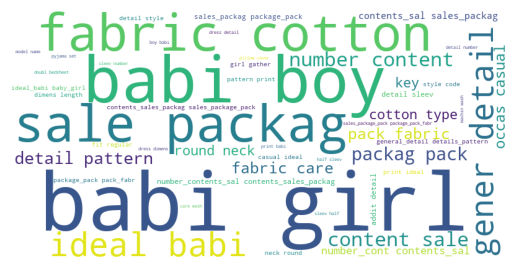

In [ ]:
#  Visualisation des tokens de la catégorie "Baby Care"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_0))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

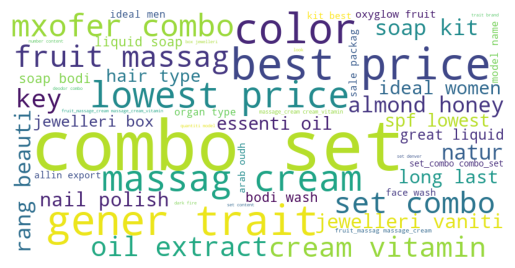

In [ ]:
#  Visualisation des tokens de la catégorie "Beauty and Personal Care"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_1))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

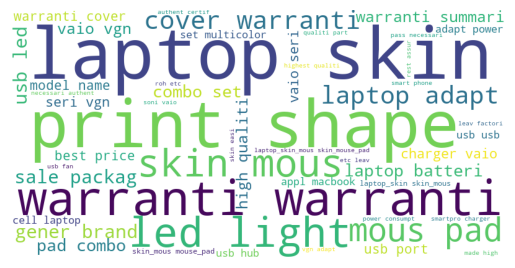

In [ ]:
#  Visualisation des tokens de la catégorie "Computers"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

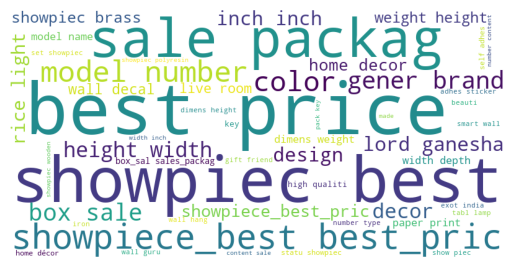

In [ ]:
#  Visualisation des tokens de la catégorie "Home Decor and Festive Needs"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

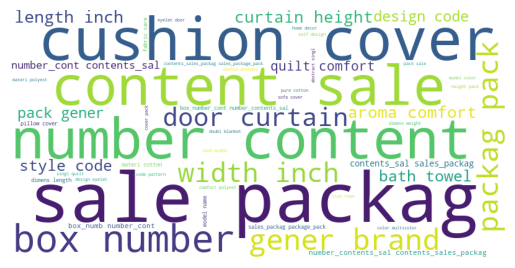

In [ ]:
#  Visualisation des tokens de la catégorie "Home Furnishing"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_4))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

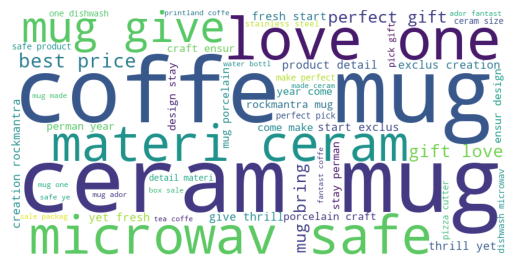

In [ ]:
#  Visualisation des tokens de la catégorie "Kitchen and Dining"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

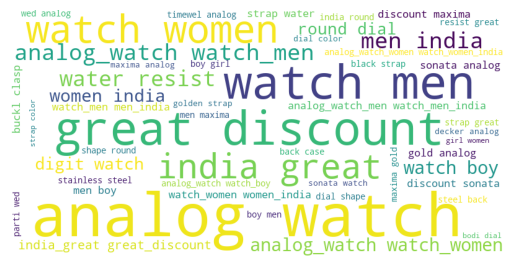

In [ ]:
#  Visualisation des tokens de la catégorie "Watches"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Nettoyage final

In [ ]:
data_txt_sep['description_preprocessed'] = data_txt_sep.description.apply(lambda txt: preprocess3(txt, stopword_liste, 2, 700, 3, stem_lemm="stem"))

data_txt_sep

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_niv_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                   cat_niv_2  _taille_description  cat_niv_1_num  \
0     Curtains & Accessories                 1420              4   
1           Baby Bath & Skin                  444              0   
2           Baby Bath & Skin                 1258              0   
3                  Bed Linen                  858              4   
4                  Bed Linen                 1197              4   
...                      ...                  ...            ...   
1045       Baby & Kids Gifts                 2432              0   
1046       Baby & Kids Gifts                 1660              0   
1047       Baby & Kids Gifts                  262              0   
1048       Baby & Kids Gifts                  210              0   
1049       Baby & Kids Gifts                  187              0   

                               description_preprocessed  
0     [key, eleg, polyest, multicolor, abstract, eye...  
1     [sathiya, cotton, bath, towel, bath, towel, re...  
2     [key, eurospa, cotton, terri, face, towel, set...  
3     [key, santosh, royal, fashion, cotton, print, ...  
4     [key, jaipur, print, cotton, floral, king, siz

In [ ]:
# fonction pour filtrer les tokens
def filter_tokens(tokens: list,
                  corpus: list) -> list :
  '''Filtrage d'une liste de tokens en fonction d'une liste référente de tokens
   Args:
        tokens (list): Liste de tokens à comparer
        corpus (list): Liste de tokens référente
  Sortie:
        Liste de tokens filtrés
  '''
  return [token for token in tokens if token in corpus]

In [ ]:
# Appliquer preprocess3 à chaque ligne du dataframe (en ne filtrant pas sur la fréquence) et filtrer les tokens en fonction de la liste de tokens trouvés avec preprocess3 sur tout le corpus
data_txt_sep['description_token'] = data_txt_sep.description.apply(lambda txt: filter_tokens(preprocess3(txt, stopword_liste, 1, 1000, 3, stem_lemm="stem"), corpus_tokenised_3_stem))
data_txt_sep

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_niv_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                   cat_niv_2  _taille_description  cat_niv_1_num  \
0     Curtains & Accessories                 1420              4   
1           Baby Bath & Skin                  444              0   
2           Baby Bath & Skin                 1258              0   
3                  Bed Linen                  858              4   
4                  Bed Linen                 1197              4   
...                      ...                  ...            ...   
1045       Baby & Kids Gifts                 2432              0   
1046       Baby & Kids Gifts                 1660              0   
1047       Baby & Kids Gifts                  262              0   
1048       Baby & Kids Gifts                  210              0   
1049       Baby & Kids Gifts                  187              0   

                               description_preprocessed  \
0     [key, eleg, polyest, multicolor, abstract, eye...   
1     [sathiya, cotton, bath, towel, bath, towel, re...   
2     [key, eurospa, cotton, terri, face, towel, set...   
3     [key, santosh, royal, fashion, cotton, print, ...   
4     [key, jaipur, print, cotton, floral, king

In [ ]:
# Comptons le nombre de tokens unique pour vérifier qu'on a le même nombre que dans le corpus entier
all_tokens = [token for tokens in data_txt_sep['description_token'] for token in tokens]
unique_word_count = len(set(all_tokens))
unique_word_count

19584

In [ ]:
data_txt_sep.to_csv("D:/tutorial-env/OCR/Projet6/data_txt_preprocessed.csv", index = False)

## Vectorisation :

###  Bags of words : CountVectorizer

Ce modèle renvoie une matrice comptant le nombre d'occurence des tokens dans l'ensemble du corpus.  

In [ ]:
# Convertir les listes de tokens en texte pour le vecteurisateur
data_txt_sep['processed_text_str'] = data_txt_sep['description_token'].apply(lambda tokens: ' '.join(tokens))

# Vectorisation
model = CountVectorizer(min_df=1)
X = model.fit_transform(data_txt_sep['processed_text_str'])

# Création d'un DataFrame pour le stockage des résultats :
df_CountVec = pd.DataFrame(X.toarray(),columns=model.get_feature_names_out())
df_CountVec2 = df_CountVec.copy()

print(f"Dimension du DataFrame de vectorisation : {df_CountVec.shape}")

Dimension du DataFrame de vectorisation : (1050, 19584)


In [ ]:
df_CountVec

aaa  aapno  aapno_rajasthan  aapno_rajasthan_lov  \
0       0      0                0                    0   
1       0      0                0                    0   
2       0      0                0                    0   
3       0      0                0                    0   
4       0      0                0                    0   
...   ...    ...              ...                  ...   
1045    0      0                0                    0   
1046    0      0                0                    0   
1047    0      0                0                    0   
1048    0      0                0                    0   
1049    0      0                0                    0   

      aapno_rajasthan_marvel  aapno_rajasthan_princess  aari  aari_embroid  \
0                          0                         0     0             0   
1                          0                         0     0             0   
2                          0                         0     0             0   
3                          0                         0     0             0   
4                          0                         0     0             0   
...                      ...                       ...   ...           ...   
1045                       0                         0     0             0   
1046                       0                         0     0             0   
1047                       0                         0     0             0   
1048                       0                         0     0             0   
1049                       0                         0     0             0   

      aari_embroidered_black  aari_embroideri  ...  zipexterior  zipper  zone  \
0                          0                0  ...            0       0     0   
1                          0                0  ...            0       0     0   
2                          0                0  ...            0       0     0   
3                          0                0  ...            0       0     0   
4                          0                0  ...            0       0     0   
...                      ...              ...  ...          ...     ...   ...   
1045                       0                0  ...            0       0     0   
1046                       0                0  ...            0       0     0   
1047                       0                0  ...            0       0     0   
1048                       0                0  ...            0       0     0   
1049                       0                0  ...            0       0     0   

      zone_print  zone_printed_back  zoom  zora  zora_laptop  \
0              0                  0     0     0            0   
1              0                  0     0     0            0   
2              0                  0     0     0            0   
3              0                  0     0     0            0   
4              0                  0     0     0            0   
...          ...                ...   ...   ...          ...   
1045           0                  0     0     0            0   
1046           0                  0     0     0            0   
1047           0                  0     0     0            0   
1048           0                  0     0     0            0   
1049           0                  0     0     0            0   

      zora_laptop_skin  zyxel  
0                    0      0  
1                    0      0  
2                    0      0  
3                    0      0  
4                    0      0  
...                ...    ...  
1045                 0      0  
1046                 0      0  
1047                 0      0  
1048                 0      0  
1049                 0      0  

[1050 rows x 19584 columns]

In [ ]:
data_txt_sep

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_niv_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                   cat_niv_2  _taille_description  cat_niv_1_num  \
0     Curtains & Accessories                 1420              4   
1           Baby Bath & Skin                  444              0   
2           Baby Bath & Skin                 1258              0   
3                  Bed Linen                  858              4   
4                  Bed Linen                 1197              4   
...                      ...                  ...            ...   
1045       Baby & Kids Gifts                 2432              0   
1046       Baby & Kids Gifts                 1660              0   
1047       Baby & Kids Gifts                  262              0   
1048       Baby & Kids Gifts                  210              0   
1049       Baby & Kids Gifts                  187              0   

                               description_preprocessed  \
0     [key, eleg, polyest, multicolor, abstract, eye...   
1     [sathiya, cotton, bath, towel, bath, towel, re...   
2     [key, eurospa, cotton, terri, face, towel, set...   
3     [key, santosh, royal, fashion, cotton, print, ...   
4     [key, jaipur, print, cotton, floral, king

####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [ ]:
# Réduction de dimension par PCA

pca =  PCA(n_components = 500)
pca.fit(df_CountVec)


df_CountVec_pca = pca.transform(df_CountVec)

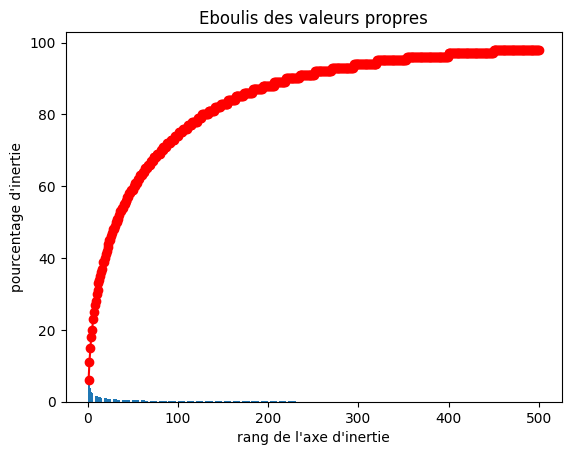

In [ ]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 501)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c = "red",marker = 'o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

In [ ]:
np.where(scree_cum == 95.)[0][0]

320

En prenant les 242 premiers composant de la PCA, on explique 95% de la matrice creuse.

In [ ]:
df_CountVec_pca = pd.DataFrame(df_CountVec_pca[:,:320])
df_CountVec_pca.shape

(1050, 320)

In [ ]:
df_CountVec_pca

0          1          2         3         4          5         6    \
0     2.220995   4.173362   7.457656  1.839327  1.324553   6.880063 -1.631888   
1    -1.174547   2.487053   6.211508 -0.521242 -0.113167   2.825867 -0.338072   
2     0.123143   8.017068  13.296611  1.518092  1.754213   3.837696  2.083842   
3    -0.239800   8.016421  15.698326  0.670730  0.370045   9.498447 -1.613444   
4     0.238996  12.047972  19.492178  0.564487  2.037003  11.863755 -1.108548   
...        ...        ...        ...       ...       ...        ...       ...   
1045 -0.311262   3.198404   1.997511  4.784955  5.046876  11.482799 -1.641980   
1046  3.479251   6.197901   3.324529  4.915444  6.727645   8.165381  2.722477   
1047 -1.758646  -2.031487  -2.105498  0.291974  0.041188   0.322772  0.064795   
1048 -1.781904  -1.986724  -1.997644  0.452955  0.196129   0.611408 -0.250040   
1049 -1.771154  -2.015829  -2.055612  0.399840  0.050856   0.282001 -0.166233   

           7          8         9    ...       310       311       312  \
0    -0.133446  -3.664153 -0.590685  ... -0.051889 -0.376259 -0.082143   
1    -1.046451   1.567840 -0.316118  ... -0.894436  0.309728 -0.115392   
2     0.020817   4.380059  0.589361  ... -0.168599  0.030100  0.344353   
3    -3.075583  20.197802 -9.450896  ...  0.377787  1.532538 -1.304440   
4    -1.873319  23.798048 -8.959384  ... -0.383931 -1.288144  1.041417   
...        ...        ...       ...  ...       ...       ...       ...   
1045  0.415856 -17.659935  6.469880  ...  0.128156 -0.118606 -0.072068   
1046  1.767536  -5.934408  2.062067  ... -0.032987 -0.130164 -0.086577   
1047  0.034032  -0.446684 -1.500276  ... -0.933072  0.906260  1.067940   
1048 -0.354305  -1.152689 -1.117808  ...  0.473160 -0.308312 -0.198222   
1049 -0.272427  -0.554766 -1.384298  ... -0.324816  0.352404  0.431063   

           313       314       315       316       317       318       319  
0    -0.101156  0.202157  0.639460 -0.081178  0.089835 -0.002877  0.021874  
1     0.140238  0.236433  0.234152  0.019140 -0.574409 -0.309807  0.833618  
2    -0.106175  0.295754 -0.344052 -0.040199 -0.353456  0.418579 -0.047481  
3    -0.237437  0.248897  0.244039  1.068062 -1.616319  0.529291 -1.873499  
4     0.287481 -0.524487  0.079531 -0.234058  0.709467 -0.947672  0.861379  
...        ...       ...       ...       ...       ...       ...       ...  
1045 -0.000535  0.026130 -0.015503 -0.001308  0.079794  0.012323  0.026576  
1046 -0.065708  0.116696  0.212442  0.033544  0.217465  0.136803  0.058832  
1047  1.412381 -1.368357  1.511019 -1.098273  0.652288 -0.895881  1.761916  
1048 -0.501038  0.627347 -0.637355  0.399609 -0.546808  0.413964 -0.941110  
1049  0.480053 -0.426081  0.500626 -0.440832  0.155036 -0.362767  0.542475  

[1050 rows x 320 columns]

####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne_CountVec = tsne.fit_transform(df_CountVec_pca)

In [ ]:
df_tsne_CountVec = pd.DataFrame(X_tsne_CountVec, columns=['tsne1', 'tsne2'])
df_tsne_CountVec["class_reelle"] = data_txt_sep["cat_niv_1_num"]

####  *Clustering KMeans*


In [ ]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne_CountVec)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [ ]:
df_tsne_CountVec["class_predite"] = kmeans.labels_

In [ ]:
df_tsne_CountVec.groupby('class_predite').size()

class_predite
0    153
1    194
2    151
3    123
4     75
5    226
6    128
dtype: int64

####  *Visualisation des clusters*

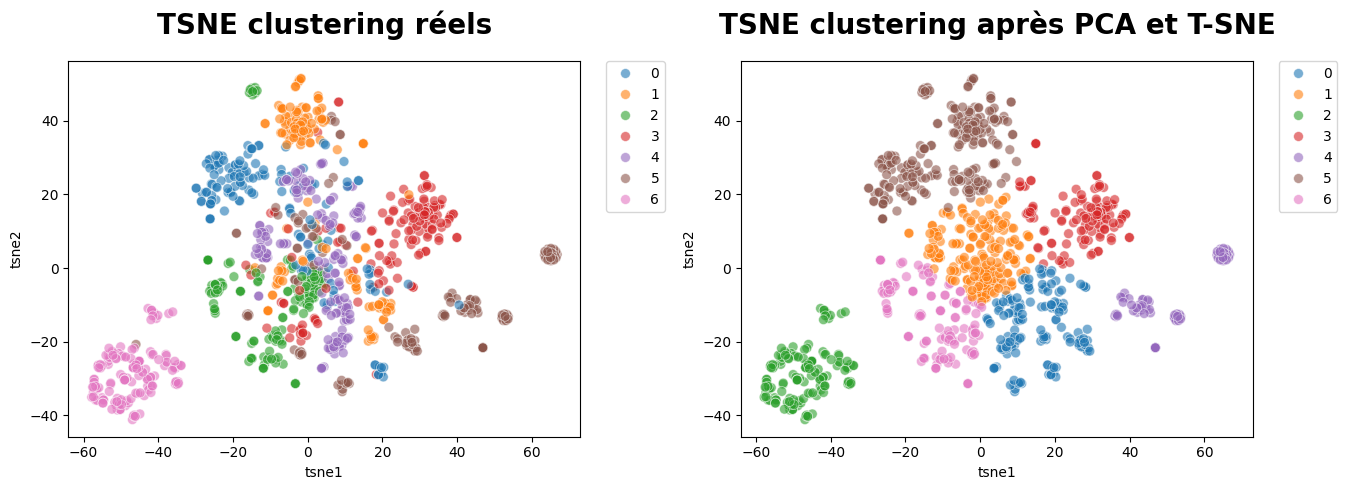

In [ ]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_CountVec,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_CountVec,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

Nous avons une répartition plutôt équilibrée de nos clusters proche de la classification initiale du jeu de données (150 pour chaque catégorie).

In [ ]:
# Calcul de l'ARI entre les paires de labels
ari_CountVec = adjusted_rand_score(df_tsne_CountVec["class_reelle"], df_tsne_CountVec["class_predite"])
print(f"Le score ARI est de :", ari_CountVec)



Le score ARI est de : 0.3725174448637842


Avec la méthode CountVectorizer, le clustering est plutôt équilibré comme le clustering initial mais le score ARI reste moyen donc environ la moitié des individus ne sont pas dans le bon cluster.

###  Bags of words : Tf-idf

Le TF-IDF (Term Frequency-Inverse Document Frequency) est une méthode utilisée pour évaluer l'importance d'un mot dans un document par rapport à l'ensemble du corpus.

Term Frequency (TF) : Il s'agit de la fréquence d'un mot dans un document donné. Plus un mot apparaît souvent dans un document, plus son TF est élevé.

Inverse Document Frequency (IDF) : Il mesure l'importance d'un mot dans l'ensemble du corpus. Si un mot apparaît dans de nombreux documents, son IDF sera faible, ce qui signifie qu'il est moins informatif. L'IDF est calculé en prenant le logarithme du rapport entre le nombre total de documents et le nombre de documents contenant le mot.

La formule complète est : TF-IDF(t,d)=TF(t,d)×IDF(t)

En résumé, le TF-IDF permet de pondérer les mots d'un document pour qu'ils reflètent leur importance relative dans le contexte du corpus, ce qui est particulièrement utile pour des tâches comme la recherche d'informations ou le clustering de textes.

In [ ]:
# Vectorisation
model = TfidfVectorizer(min_df=1)
X = model.fit_transform(data_txt_sep['processed_text_str'])

# Création d'un DataFrame pour le stockage des résultats :
df_Tfidf = pd.DataFrame(X.toarray(),columns=model.get_feature_names_out())
df_Tfidf2 = df_Tfidf.copy()

print(f"Dimension du DataFrame de vectorisation : {df_Tfidf.shape}")

Dimension du DataFrame de vectorisation : (1050, 19584)


In [ ]:
df_Tfidf

aaa  aapno  aapno_rajasthan  aapno_rajasthan_lov  \
0     0.0    0.0              0.0                  0.0   
1     0.0    0.0              0.0                  0.0   
2     0.0    0.0              0.0                  0.0   
3     0.0    0.0              0.0                  0.0   
4     0.0    0.0              0.0                  0.0   
...   ...    ...              ...                  ...   
1045  0.0    0.0              0.0                  0.0   
1046  0.0    0.0              0.0                  0.0   
1047  0.0    0.0              0.0                  0.0   
1048  0.0    0.0              0.0                  0.0   
1049  0.0    0.0              0.0                  0.0   

      aapno_rajasthan_marvel  aapno_rajasthan_princess  aari  aari_embroid  \
0                        0.0                       0.0   0.0           0.0   
1                        0.0                       0.0   0.0           0.0   
2                        0.0                       0.0   0.0           0.0   
3                        0.0                       0.0   0.0           0.0   
4                        0.0                       0.0   0.0           0.0   
...                      ...                       ...   ...           ...   
1045                     0.0                       0.0   0.0           0.0   
1046                     0.0                       0.0   0.0           0.0   
1047                     0.0                       0.0   0.0           0.0   
1048                     0.0                       0.0   0.0           0.0   
1049                     0.0                       0.0   0.0           0.0   

      aari_embroidered_black  aari_embroideri  ...  zipexterior  zipper  zone  \
0                        0.0              0.0  ...          0.0     0.0   0.0   
1                        0.0              0.0  ...          0.0     0.0   0.0   
2                        0.0              0.0  ...          0.0     0.0   0.0   
3                        0.0              0.0  ...          0.0     0.0   0.0   
4                        0.0              0.0  ...          0.0     0.0   0.0   
...                      ...              ...  ...          ...     ...   ...   
1045                     0.0              0.0  ...          0.0     0.0   0.0   
1046                     0.0              0.0  ...          0.0     0.0   0.0   
1047                     0.0              0.0  ...          0.0     0.0   0.0   
1048                     0.0              0.0  ...          0.0     0.0   0.0   
1049                     0.0              0.0  ...          0.0     0.0   0.0   

      zone_print  zone_printed_back  zoom  zora  zora_laptop  \
0            0.0                0.0   0.0   0.0          0.0   
1            0.0                0.0   0.0   0.0          0.0   
2            0.0                0.0   0.0   0.0          0.0   
3            0.0                0.0   0.0   0.0          0.0   
4            0.0                0.0   0.0   0.0          0.0   
...          ...                ...   ...   ...          ...   
1045         0.0                0.0   0.0   0.0          0.0   
1046         0.0                0.0   0.0   0.0          0.0   
1047         0.0                0.0   0.0   0.0          0.0   
1048         0.0                0.0   0.0   0.0          0.0   
1049         0.0                0.0   0.0   0.0          0.0   

      zora_laptop_skin  zyxel  
0                  0.0    0.0  
1                  0.0    0.0  
2                  0.0    0.0  
3                  0.0    0.0  
4                  0.0    0.0  
...                ...    ...  
1045               0.0    0.0  
1046               0.0    0.0  
1047               0.0    0.0  
1048               0.0    0.0  
1049               0.0    0.0  

[1050 rows x 19584 columns]

####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [ ]:
# Réduction de dimension par PCA

pca =  PCA(n_components = 800)
pca.fit(df_Tfidf)


df_Tfidf_pca = pca.transform(df_Tfidf)

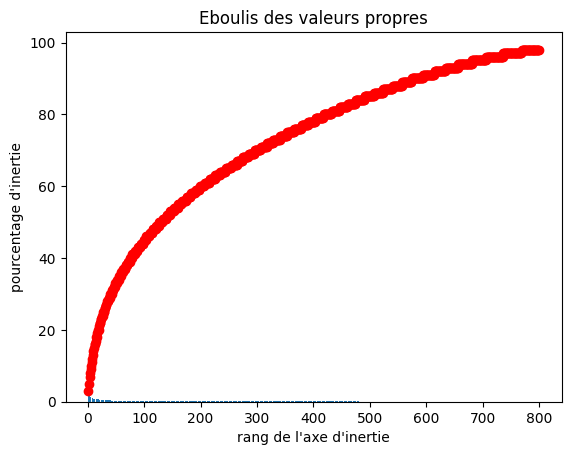

In [ ]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 801)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c = "red",marker = 'o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

In [ ]:
np.where(scree_cum == 95.)[0][0]

681

En prenant les 681 premiers composant de la PCA, on explique 95% de la matrice creuse.

In [ ]:
df_Tfidf_pca = pd.DataFrame(df_Tfidf_pca[:,:681])
df_Tfidf_pca.shape

(1050, 681)

In [ ]:
df_Tfidf_pca

0         1         2         3         4         5         6    \
0    -0.090107 -0.035166  0.002780  0.031046 -0.118738 -0.056308  0.163462   
1    -0.062835 -0.086918  0.110928  0.003194  0.019182 -0.054483 -0.003823   
2    -0.080737 -0.069087  0.067427 -0.032767  0.109579 -0.030023  0.008102   
3    -0.085269 -0.071686  0.091190  0.010810 -0.078053 -0.012908  0.134392   
4    -0.094936 -0.068724  0.090236  0.000962 -0.087145 -0.005078  0.138885   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.044168 -0.035130 -0.048115 -0.013618 -0.044405 -0.008686 -0.032688   
1046 -0.065960  0.008070 -0.036780 -0.022432 -0.053855  0.010339 -0.014201   
1047 -0.036624 -0.034561 -0.058710 -0.014763 -0.031561 -0.023817 -0.074450   
1048 -0.044035 -0.041159 -0.075309 -0.019470 -0.052310 -0.034146 -0.112770   
1049 -0.041728 -0.038461 -0.071901 -0.017178 -0.045086 -0.029704 -0.103177   

           7         8         9    ...       671       672       673  \
0     0.041199  0.268976  0.089944  ...  0.000227 -0.000744 -0.005587   
1     0.628000 -0.081759  0.001326  ...  0.000111 -0.001759  0.003403   
2     0.450366 -0.055381  0.002319  ... -0.000272 -0.000913  0.003903   
3     0.121231  0.134975 -0.031925  ...  0.002310  0.000812 -0.001772   
4     0.135713  0.134770 -0.039225  ... -0.002075 -0.002743 -0.001573   
...        ...       ...       ...  ...       ...       ...       ...   
1045  0.002872  0.034872  0.000042  ... -0.000354  0.000318  0.000514   
1046  0.021583  0.072804  0.002535  ...  0.000341 -0.000089  0.002068   
1047 -0.018247 -0.009637  0.008510  ...  0.000393  0.000215 -0.000170   
1048 -0.019294  0.009276  0.017410  ... -0.000081  0.000198 -0.001473   
1049 -0.023135 -0.000528  0.010181  ... -0.001302 -0.000893  0.000933   

           674       675       676       677       678       679       680  
0     0.004163 -0.015695  0.012913  0.020247  0.023620 -0.045785 -0.013462  
1     0.003984 -0.070671  0.006911  0.028181  0.050099  0.053860 -0.001990  
2    -0.001227 -0.018927 -0.012022  0.008884 -0.013866 -0.010409  0.011767  
3     0.002168 -0.016326  0.003066 -0.017660  0.013284  0.017475 -0.055227  
4    -0.001130  0.003915  0.006476 -0.000154  0.004427 -0.052030  0.038488  
...        ...       ...       ...       ...       ...       ...       ...  
1045 -0.000076  0.005442 -0.001588  0.006386  0.025498 -0.005822 -0.004339  
1046 -0.000357  0.010851 -0.011006 -0.000541 -0.023327  0.020343  0.001011  
1047  0.000554 -0.004050 -0.002611  0.010305 -0.006856  0.007411  0.006965  
1048  0.000051  0.001730 -0.001549  0.008821  0.005565  0.003819  0.016148  
1049 -0.001296  0.009900 -0.010671  0.009918  0.021849 -0.011844  0.020824  

[1050 rows x 681 columns]

####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne_Tfidf = tsne.fit_transform(df_Tfidf_pca)

In [ ]:
df_tsne_Tfidf = pd.DataFrame(X_tsne_Tfidf, columns=['tsne1', 'tsne2'])
df_tsne_Tfidf["class_reelle"] = data_txt_sep["cat_niv_1_num"]

####  *Clustering KMeans*

In [ ]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne_Tfidf)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [ ]:
df_tsne_Tfidf["class_predite"] = kmeans.labels_

In [ ]:
df_tsne_Tfidf.groupby('class_predite').size()

class_predite
0    164
1    160
2     79
3     76
4    200
5    187
6    184
dtype: int64

Nous avons une répartition plus équilibrée qu'avec CountVectorizer.

####  *Visualisation des clusters*

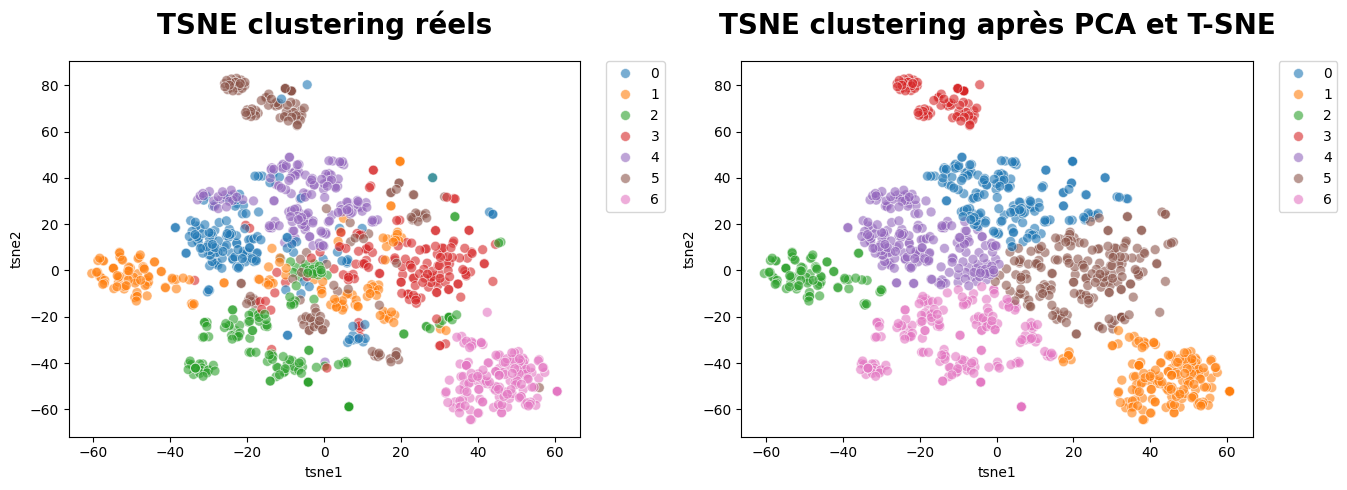

In [ ]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_Tfidf,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_Tfidf,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

Nous avons une répartition plutôt équilibrée de nos clusters proche de la classification initiale du jeu de données (150 pour chaque catégorie).

In [ ]:
# Calcul de l'ARI entre les paires de labels
ari_Tfidf = adjusted_rand_score(df_tsne_Tfidf["class_reelle"], df_tsne_Tfidf["class_predite"])
print(f"Le score ARI est de :", ari_Tfidf)

Le score ARI est de : 0.45140434006123614


Avec la méthode Tf-idf, le clustering est plutôt équilibré comme le clustering initial mais le score ARI reste moyen donc environ la moitié des individus ne sont pas dans le bon cluster.

###  Word embedding classique : Word2Vec  

C'est une ensemble de modèles de réseaux de neurones composés de 3 couches qui convertit les mots en vecteurs numériques (proche en cas de similitude contextuelle des mots).

Cet ensemble est composé de deux modèles disctincts :
- **CBOW (Continus Bag of Words)** : ce modèle tente de prédire un mot cible en se basant sur le contexte des mots voisins.
- **Skip-gram** : A l'inverse, celui-ci tente la prédiction des mots voisins à partir d'un mot cible.


In [ ]:
# Vectorisation

# vector_size : La taille des vecteurs de mots. Des tailles courantes sont 100, 200 ou 300. Des vecteurs plus grands capturent plus de nuances, mais augmentent également le temps de calcul.
# window : La taille du contexte autour d'un mot (à gauche et à droite). Un plus grand contexte peut capturer des relations plus larges, tandis qu'un plus petit se concentre sur les relations immédiates.
# min_count : Le nombre minimum d'occurrences d'un mot pour être inclus dans le vocabulaire. Des valeurs plus élevées aident à filtrer le bruit.
# workers : Le nombre de threads à utiliser lors de l'entraînement. Plus de threads peuvent réduire le temps d'entraînement, mais cela dépend de votre matériel.

model = Word2Vec(data_txt_sep['description_token'],
                 vector_size = 100,
                 window = 5,
                 min_count = 1,
                 workers = 4
                 )

model.save("word2vec.model")

In [ ]:
#Liste pour stocker les vecteurs de chaque document
doc_vectors = []
doc_vector = []

#Calcul du vecteur pour chaque document
for doc in data_txt_sep['description_token']:
  word_vector = []
  for word in doc:

    # Vérifier si le mot est dans le modèle de Word2Vec
    if word in model.wv:
      word_vector.append(model.wv[word])

  #Si des vecteurs ont été trouvés, calculer le vecteur moyen, sinon vecteur nul
  if word_vector:
    doc_vector.append(np.mean(word_vector, axis=0))
  else:
    doc_vector.append(np.zeros(model.vector_size))

  doc_vectors = np.array(doc_vector)

doc_vectors_array = np.array(doc_vectors)
df_Word2Vec = pd.DataFrame(doc_vectors_array)
df_Word2Vec

0         1         2         3         4         5         6   \
0    -0.133624  0.428904 -0.013798  0.081211 -0.310603 -0.543427  0.861344   
1    -0.215001  0.712373  0.024526  0.058690 -0.392132 -0.736732  1.007040   
2    -0.106877  0.497300  0.045181  0.167774 -0.436758 -0.574347  0.963212   
3    -0.077200  0.498870  0.079855 -0.022176 -0.380641 -0.633574  0.907664   
4    -0.073169  0.465724  0.106083  0.026861 -0.390757 -0.614233  0.931441   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.071309  0.152494 -0.042563  0.023046 -0.101459 -0.216835  0.382053   
1046 -0.045271  0.175842 -0.014442  0.091339 -0.209246 -0.317871  0.619781   
1047 -0.020989  0.100361 -0.075166  0.001776 -0.093093 -0.280230  0.350182   
1048 -0.018960  0.152898 -0.140087 -0.010568 -0.178678 -0.507177  0.626428   
1049 -0.011015  0.142070 -0.131202 -0.000556 -0.163090 -0.490983  0.608421   

            7         8         9   ...        90        91        92  \
0     0.915919 -0.394627 -0.409406  ...  0.329459  0.329643  0.283996   
1     1.241773 -0.546203 -0.477540  ...  0.775034  0.280985  0.272889   
2     1.112149 -0.497827 -0.378131  ...  0.568037  0.284358  0.260863   
3     1.048345 -0.375968 -0.410935  ...  0.519424  0.237360  0.261571   
4     1.052185 -0.407800 -0.408882  ...  0.484221  0.259107  0.262823   
...        ...       ...       ...  ...       ...       ...       ...   
1045  0.358404 -0.129671 -0.176736  ... -0.008266  0.160059  0.147385   
1046  0.580347 -0.237203 -0.264042  ... -0.036605  0.255920  0.238542   
1047  0.444367 -0.105334 -0.253438  ... -0.186705  0.157151  0.301716   
1048  0.802641 -0.164817 -0.453384  ... -0.329428  0.293385  0.563720   
1049  0.788040 -0.170703 -0.452989  ... -0.376075  0.276987  0.558971   

            93        94        95        96        97        98        99  
0     0.390475  1.087750  0.428225  0.230798 -0.288969  0.035352  0.181445  
1     0.467896  1.292861  0.548274  0.354871 -0.403460 -0.009847  0.232162  
2     0.499857  1.269085  0.481219  0.294986 -0.344320  0.026557  0.306799  
3     0.367748  1.153665  0.382930  0.296793 -0.368990  0.026338  0.093545  
4     0.405228  1.209311  0.386726  0.286072 -0.371142  0.045785  0.097096  
...        ...       ...       ...       ...       ...       ...       ...  
1045  0.077598  0.458250  0.224250  0.085920 -0.123694  0.069199  0.075897  
1046  0.224327  0.774372  0.301563  0.127985 -0.187442  0.105467  0.124424  
1047  0.053348  0.455027  0.300411  0.065333 -0.122823  0.081863  0.142479  
1048  0.133216  0.809582  0.493776  0.137302 -0.224879  0.102678  0.270054  
1049  0.101717  0.795791  0.520783  0.110286 -0.212767  0.136032  0.265008  

[1050 rows x 100 columns]

####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [ ]:
# Réduction de dimension par PCA

pca =  PCA(n_components = 100)
pca.fit(df_Word2Vec)


df_Word2Vec_pca = pca.transform(df_Word2Vec)

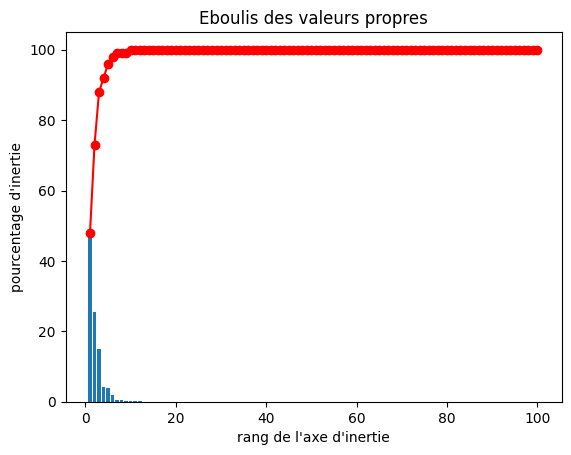

In [ ]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 101)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c = "red",marker = 'o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

In [ ]:
np.where(scree_cum > 95.)[0][0]

4

En prenant les 4 premiers composant de la PCA, on explique plus de  95% de la matrice creuse.

In [ ]:
df_Word2Vec_pca = pd.DataFrame(df_Word2Vec_pca[:,:4])
df_Word2Vec_pca.shape

(1050, 4)

In [ ]:
df_Word2Vec_pca

0         1         2         3
0    -0.341998  0.796021 -0.074253 -0.201441
1     0.768440  1.684255 -0.626466 -0.206424
2     0.115671  1.545641 -0.392675 -0.074893
3    -0.195622  1.170049 -0.394770 -0.549600
4    -0.233823  1.262333 -0.313964 -0.538949
...        ...       ...       ...       ...
1045 -1.673959 -1.282902 -0.256849  0.066477
1046 -1.293906 -0.378438  0.153452 -0.046905
1047 -1.625580 -1.192475  0.245198  0.154629
1048 -0.920829 -0.099370  1.123524  0.025765
1049 -0.893654 -0.230134  1.202070  0.073389

[1050 rows x 4 columns]

####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne_Word2Vec = tsne.fit_transform(df_Word2Vec_pca)

In [ ]:
df_tsne_Word2Vec = pd.DataFrame(X_tsne_Word2Vec, columns=['tsne1', 'tsne2'])
df_tsne_Word2Vec["class_reelle"] = data_txt_sep["cat_niv_1_num"]

####  *Clustering KMeans*

In [ ]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne_Word2Vec)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [ ]:
df_tsne_Word2Vec["class_predite"] = kmeans.labels_

In [ ]:
df_tsne_Word2Vec.groupby('class_predite').size()

class_predite
0    150
1    100
2    154
3    135
4    150
5    197
6    164
dtype: int64

Nous avons une répartition plus équilibrée qu'avec CountVectorizer, semblable à Tf-idf.

####  *Visualisation des clusters*

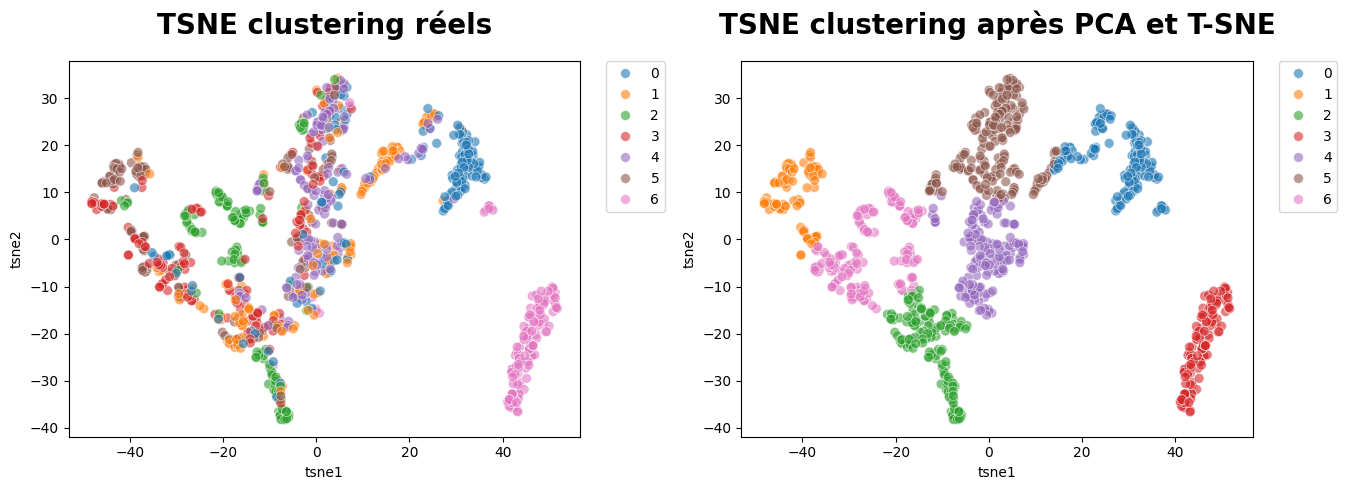

In [ ]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_Word2Vec,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_Word2Vec,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

Nous avons une répartition plutôt équilibrée de nos clusters proche de la classification initiale du jeu de données (150 pour chaque catégorie).

In [ ]:
# Calcul de l'ARI entre les paires de labels
ari_Word2Vec = adjusted_rand_score(df_tsne_Word2Vec["class_reelle"], df_tsne_Word2Vec["class_predite"])
print(f"Le score ARI est de :", ari_Word2Vec)

Le score ARI est de : 0.2630184818584555


Avec la méthode Word2Vec, le clustering est plutôt équilibré comme le clustering initial mais le score ARI est bas donc environ les trois-quart des individus ne sont pas dans le bon cluster.

###  Word embedding : BERT

C'est une modèle de traitement du langage naturel (NLP) avec une architecture TRANSFORMER développé par Google en 2018, conçu pour améliorer les performances des tâches de compréhension du langage dans un contexte global.

In [ ]:
# Convertir les listes de tokens en texte pour le vecteurisateur
data_txt_sep['processed_text_str'] = data_txt_sep['description_token'].apply(lambda tokens: ' '.join(tokens))

# Charger le tokenizer spécifique pour BERT et le modele BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

doc_vectors = []

# Calculer le vecteur de chaque document
for doc in data_txt_sep['processed_text_str']:

    # Utiliser le tokenizer BERT sur les tokens identifiés de chaque document
    inputs = tokenizer(doc, return_tensors='pt', padding=True, truncation=True)

    # Passer les tokens BERT au modèle
    with torch.no_grad():
        outputs = model(**inputs)

    #Obtenir les embeddings (dernière couche cachée et utiliser le premier token (CLS) pour représenter le document)
    doc_vector = outputs.last_hidden_state[0, 0, :].numpy()
    doc_vectors.append(doc_vector)

df_BERT = pd.DataFrame(doc_vectors)
df_BERT


0         1         2         3         4         5         6    \
0    -0.786068 -0.051407 -0.357667 -0.375618 -0.644042  0.119490  0.174212   
1    -0.634219  0.406464 -0.393522 -0.148058 -0.693373 -0.082244  0.313322   
2    -0.498066  0.082487 -0.191346 -0.198693 -0.338491  0.079499  0.035664   
3    -0.438470  0.006750 -0.163311 -0.118871 -0.559485 -0.078969  0.034918   
4    -0.582714  0.053217 -0.427450 -0.210618 -0.415614 -0.147448  0.087992   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.681702  0.273650 -0.280766 -0.287719 -0.592888  0.142786  0.288612   
1046 -0.791772  0.178126 -0.023788 -0.343032 -0.565781  0.207780  0.258400   
1047 -0.480347  0.417730 -0.574158 -0.170932 -0.458461  0.099385 -0.161542   
1048 -0.902860  0.553030 -0.057616  0.014452 -0.577511  0.034126  0.369515   
1049 -0.811832  0.168867 -0.278775  0.009533 -0.438467  0.308437  0.190022   

           7         8         9    ...       758       759       760  \
0     0.503118 -0.644992 -0.028096  ...  0.351183 -0.475194 -0.169792   
1     0.297050 -0.833776  0.517689  ...  0.092700 -0.364486 -0.105784   
2     0.252073 -0.476806  0.363254  ...  0.273215 -0.507948 -0.222122   
3     0.495324 -0.626446  0.265948  ...  0.226680 -0.433544 -0.197963   
4     0.540928 -0.577552  0.152972  ...  0.321333 -0.369374 -0.071470   
...        ...       ...       ...  ...       ...       ...       ...   
1045  0.329126 -0.261563 -0.361834  ...  0.384554 -0.529504 -0.029275   
1046  0.549113 -0.296481 -0.195478  ...  0.342897 -0.658104 -0.218522   
1047  0.092493 -0.618704  0.265931  ...  0.207240 -0.337132 -0.517312   
1048  0.212886 -0.654447  0.388774  ... -0.126314 -0.837168 -0.255533   
1049  0.282812 -0.351770  0.178160  ... -0.016594 -0.554852 -0.314148   

           761       762       763       764       765       766       767  
0     0.265665  0.020453  0.037669 -0.278474 -0.303244  0.183932  0.075899  
1     0.025033  0.212584  0.087601 -0.205678 -0.649344  0.163258 -0.289730  
2     0.214320  0.186443  0.148033 -0.370856 -0.344982 -0.042414  0.013887  
3     0.107701  0.255881  0.110428 -0.318249 -0.452916  0.055766 -0.303738  
4     0.127426  0.198486  0.168473 -0.551520 -0.260405  0.192498 -0.242861  
...        ...       ...       ...       ...       ...       ...       ...  
1045  0.265890  0.069676  0.114935 -0.557464 -0.045971  0.177274  0.334073  
1046  0.196121 -0.081171 -0.146980 -0.544830 -0.184307  0.101262 -0.084228  
1047  0.044117  0.098887  0.269989  0.052544 -0.248003  0.035280 -0.364915  
1048 -0.092831  0.534759  0.134156  0.177732 -0.165616  0.064629 -0.280304  
1049 -0.044340  0.778757  0.003534 -0.120299 -0.173460  0.017475 -0.457172  

[1050 rows x 768 columns]

####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [ ]:
# Réduction de dimension par PCA

pca =  PCA(n_components = 300)
pca.fit(df_BERT)


df_BERT_pca = pca.transform(df_BERT)

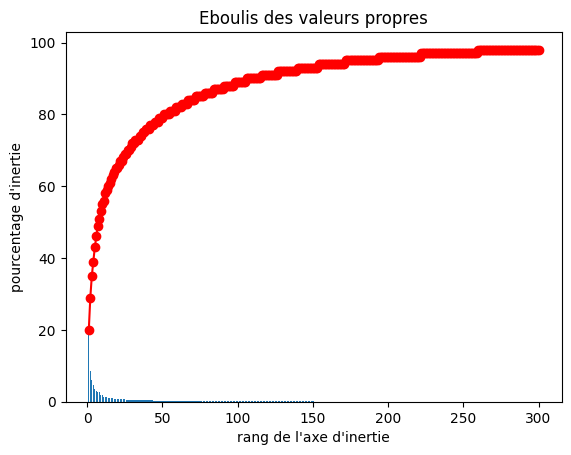

In [ ]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 301)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c = "red",marker = 'o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

In [ ]:
np.where(scree_cum == 95.)[0][0]

171

En prenant les 171 premiers composant de la PCA, on explique 95% de la matrice creuse.

In [ ]:
df_BERT_pca = pd.DataFrame(df_BERT_pca[:,:171])
df_BERT_pca.shape

(1050, 171)

In [ ]:
df_BERT_pca

0         1         2         3         4         5         6    \
0    -1.135287 -1.600910 -0.332523  2.120344 -1.212941  0.353852 -0.410124   
1    -3.367831 -1.262305  0.722397 -0.591924  0.903841 -0.921003  1.109368   
2     0.362163 -1.775927 -1.319173 -1.444459 -0.681874  0.415176 -0.253353   
3    -1.163210 -1.080691 -0.120208 -0.056407 -0.440578 -0.581708  0.356242   
4    -2.286340 -1.338992  0.670061 -0.682091 -0.272044  0.232612 -0.411920   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.005656 -2.500430 -1.083011  0.889549 -1.825769  0.894995 -1.108822   
1046 -0.843189 -1.380780 -0.567550  2.044483 -1.498166  1.172201 -0.982940   
1047 -1.104830 -0.059778  0.407438 -0.196240  1.560059 -0.230190 -0.389802   
1048 -0.588562  0.777327  1.213799  0.537575  2.380027 -0.413710  0.272494   
1049 -0.459919  0.786014  1.813008  0.258735  1.877417  0.582513  0.115286   

           7         8         9    ...       161       162       163  \
0    -0.296776  0.150492  0.061621  ... -0.024549 -0.117229 -0.141249   
1     1.243382  0.363465 -0.486978  ...  0.035430  0.025283  0.020533   
2     0.651835 -0.478938 -0.745940  ... -0.086163  0.163368 -0.108230   
3     0.836690 -0.040356 -1.273814  ... -0.012475  0.001618  0.044226   
4    -0.186339  0.603597 -0.633048  ... -0.135404 -0.161445  0.019096   
...        ...       ...       ...  ...       ...       ...       ...   
1045 -0.240747 -0.291429 -0.407079  ...  0.129428 -0.013065  0.174679   
1046 -0.467631 -0.272361 -0.849117  ...  0.011920 -0.146671 -0.042142   
1047 -0.852257 -0.600476  0.196998  ... -0.052109 -0.027849 -0.051176   
1048  0.250674 -0.847186 -0.977134  ... -0.211499  0.036843 -0.106116   
1049 -0.665428 -0.835144 -0.888294  ... -0.028142 -0.035655 -0.188756   

           164       165       166       167       168       169       170  
0     0.054493  0.142538 -0.154965 -0.004856 -0.010953 -0.143568 -0.019087  
1    -0.041052  0.166838 -0.074070 -0.011858  0.090714 -0.019066  0.047200  
2    -0.170970 -0.010384 -0.106758  0.015142  0.075619 -0.108191 -0.262135  
3    -0.057576 -0.103755 -0.114392 -0.060159 -0.043074  0.035147  0.094297  
4     0.163072 -0.143760 -0.159625  0.043535  0.059419  0.138767  0.072838  
...        ...       ...       ...       ...       ...       ...       ...  
1045  0.117552 -0.128320  0.051424 -0.117040 -0.015170  0.014425  0.212173  
1046 -0.052469  0.384422  0.083346  0.036624 -0.192152  0.037636 -0.004258  
1047 -0.026196  0.247366 -0.242225  0.109366  0.162565  0.167445 -0.262725  
1048  0.020457  0.052572  0.017931 -0.046958 -0.063640 -0.012495 -0.087086  
1049  0.107113  0.071125  0.000923  0.060715 -0.063881  0.173436  0.058578  

[1050 rows x 171 columns]

####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne_BERT = tsne.fit_transform(df_BERT_pca)

In [ ]:
df_tsne_BERT = pd.DataFrame(X_tsne_BERT, columns=['tsne1', 'tsne2'])
df_tsne_BERT["class_reelle"] = data_txt_sep["cat_niv_1_num"]

####  *Clustering KMeans*

In [ ]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne_BERT)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [ ]:
df_tsne_BERT["class_predite"] = kmeans.labels_

In [ ]:
df_tsne_BERT.groupby('class_predite').size()

class_predite
0    171
1    168
2    135
3    134
4    194
5    164
6     84
dtype: int64

Nous avons une répartition plus équilibrée qu'avec CountVectorizer, semblable aux deux autres précédents.

####  *Visualisation des clusters*

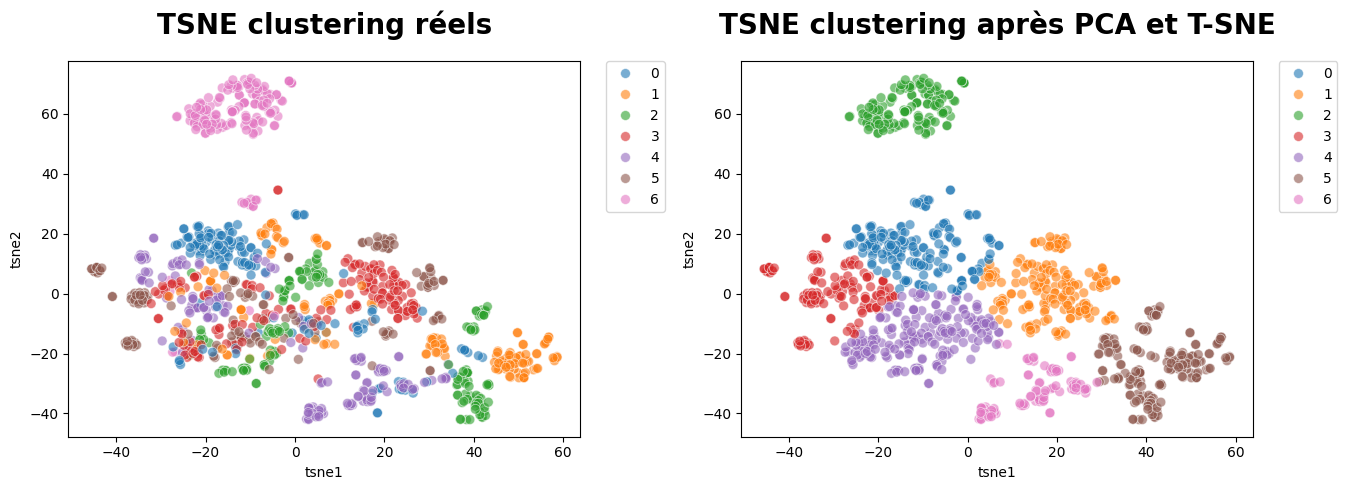

In [ ]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_BERT,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_BERT,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

Nous avons une répartition plutôt équilibrée de nos clusters proche de la classification initiale du jeu de données (150 pour chaque catégorie).

In [ ]:
# Calcul de l'ARI entre les paires de labels
ari_BERT = adjusted_rand_score(df_tsne_BERT["class_reelle"], df_tsne_BERT["class_predite"])
print(f"Le score ARI est de :", ari_BERT)

Le score ARI est de : 0.3044848574220938


Avec la méthode BERT, le clustering est plutôt équilibré comme le clustering initial mais le score ARI est bas donc environ les deux-tiers des individus ne sont pas dans le bon cluster.

###  Word embedding : USE (Universal Sentence Encoder)

Le modèle Universal Sentence Encoder (USE), développé par Google, est conçu pour convertir des phrases ou des textes entiers en vecteurs d'embeddings numériques, ce qui permet de mesurer la similarité sémantique entre différentes phrases ou textes, contrairement à BERT qui fait ça sur des mots.




-> matrice creuse

transofrmation en bag of word, tf/idf, ... sur corpus entier

reduction des vecteurs avec ACP puis clustering avec k means 7clusters, visualisation des clusters avec TSNE et calculdu score ARI.

LDA / LDA vis = approche à comparer